<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [78]:
# Load the data

house_original = pd.read_csv('./housing.csv')
house_original.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [80]:
# Basic information of data: data size, type and number of null values

print('House data size: ','column count = ', house_original.shape[1], ', ', 'row count = ', house_original.shape[0])
print('-------------------------------------------')
print('Column data types & null value counts below:')
print('-------------------------------------------')
house_original.info()

House data size:  column count =  81 ,  row count =  1460
-------------------------------------------
Column data types & null value counts below:
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 n

# 1. Data Cleaning

## Remove non-residential properties

#### Identify types of houses (from Kaggle)

- A  : Agriculture
- C  : Commercial
- FV : Floating Village Residential
- I  : Industrial
- RH : Residential High Density
- RL : Residential Low Density
- RP : Residential Low Density Park 
- RM : Residential Medium Density

In [5]:
# Check what types of properties there are in the 'House' data

print(house_original.MSZoning.unique())
print(house_original.MSZoning.value_counts())

['RL' 'RM' 'C (all)' 'FV' 'RH']
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


In [81]:
# Remove all commercial (C) properties

house_residential = house_original[house_original.MSZoning != 'C (all)']
house_residential.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

## Clean null values

In [82]:
# Find names of columns that contain null values
null_col = house_residential.columns[house_residential.isnull().any()]

# Count number of null cells
house_residential[null_col].isnull().sum()

LotFrontage      259
Alley           1361
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      681
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1443
Fence           1172
MiscFeature     1398
dtype: int64

In [83]:
# Drop the features with 1000+ numbers of null values

house_residential.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)
house_residential.shape

C:\Users\norik\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(1450, 77)

In [84]:
# Find names of columns that contain null values
null_col = house_residential.columns[house_residential.isnull().any()]

# Count number of null cells
house_residential[null_col].isnull().sum()

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     681
GarageType       79
GarageYrBlt      79
GarageFinish     79
GarageQual       79
GarageCond       79
dtype: int64

In [85]:
house_nonull_col = house_residential.columns[~house_residential.isnull().all()]
house_nonull_col

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

#### Check the nature of null values in each columns

#### 'LotFrontage' null values
Lot Frontage : Linear feet of street connected to property

In [86]:
print('Unique values of Lot Frontage from original data:')
print(house_residential.LotFrontage.unique())
print('LotFrontage null value count: ', house_residential.LotFrontage.isnull().sum())
#house[house['LotFrontage'].isnull()]

Unique values of Lot Frontage from original data:
[ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
  73.  77.  64.  94. 105.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]
LotFrontage null value count:  259


In [87]:
house_residential[house_residential['LotFrontage'].isnull()][['Street', 'LotShape']]

,Street,LotShape
7,Pave,IR1
12,Pave,IR2
14,Pave,IR1
16,Pave,IR1
24,Pave,IR1
31,Pave,IR1
42,Pave,IR1
43,Pave,IR1
50,Pave,IR2
64,Pave,Reg


In [ ]:
## Impute with linear Regression?


In [88]:
house_residential['LotFrontage'].mean()

70.0528967254408

In [89]:
# Impute mean value in null cells

house_residential.loc[house_residential['LotFrontage'].isnull(), 'LotFrontage'] = house_residential['LotFrontage'].mean()

C:\Users\norik\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [90]:
print('LotFrontage null value count: ', house_residential.LotFrontage.isnull().sum())

LotFrontage null value count:  0


In [ ]:
# Replace NaN by mean value of LotFrontage

#house.loc[house_fixed['LotFrontage'].isnull(), 'LotFrontage'] = house['LotFrontage'].mean()
#print('Unique values of Lot Frontage (NaN is replaced by a mean value):')
#print(house['LotFrontage'].unique())

In [ ]:
# Pick all numerical features

#num_fts = []

#for elem in house.columns:
    #print(elem)
    #if house[elem].dtype == np.int64 or house[elem].dtype == np.float64:
       # num_fts.append(elem)
#print('Numerical features : ', len(num_fts))
#print('--------------------------------------------------------------------------')
#print(num_fts)

In [ ]:
#num_fts = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', 'BsmtFinSF1', 
#          'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
#          'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
#          'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
#          'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

In [ ]:
#impute_cols = num_fts
#y = impute_valid.values
#X = impute_valid[impute_cols]

In [ ]:
# Standardize predictor matrix
#ss = StandardScaler()
#Xs = ss.fit_transform(X)

#### 'Alley' null values

Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

In [ ]:
#print(house.Alley.unique())

In [ ]:
#print('Unique values of Alley:', house['Alley'].unique())
#print('Alley null value count: ', house['Alley'].isnull().sum())
#house[house['Alley'].isnull()][['Alley', 'Street']].head()

In [ ]:
#house.loc[house['Alley'].isnull(), 'Alley'] = 'no_alley'

#### 'MasVnrType'  & 'MasVnrArea' null values

- MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
 
- MasVnrArea: Masonry veneer area in square feet

In [91]:
print('Unique values of MasVnrType:', house_residential['MasVnrType'].unique())
print('MasVnrType null value count: ', house_residential.MasVnrType.isnull().sum())
print('MasVnrArea null value count: ', house_residential.MasVnrType.isnull().sum())
house[house_residential.MasVnrType.isnull()][['MasVnrType', 'MasVnrArea']]

Unique values of MasVnrType: ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
MasVnrType null value count:  8
MasVnrArea null value count:  8


,MasVnrType,MasVnrArea
234,not_avail,not_avail
529,not_avail,not_avail
650,not_avail,not_avail
936,not_avail,not_avail
973,not_avail,not_avail
977,not_avail,not_avail
1243,not_avail,not_avail
1278,not_avail,not_avail


##### It appears that wherever the veneer type is NaN, the veneer area is also NaN. We will  replace NaN with not_avail.

In [92]:
house_residential.loc[house_residential['MasVnrType'].isnull(), 'MasVnrType'] = 'not_avail'
house_residential.loc[house_residential['MasVnrArea'].isnull(), 'MasVnrArea'] = 'not_avail'

#### 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1' & 'BsmtFinType2' null values

- BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
- BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement


- BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

- BsmtFinType1 & 2: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement



#### Confirm if fixed 'Bsmt' features have the NAs in the same rows.

In [93]:
Bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for i in range(len(Bsmt)):
    print('Unique values of ', Bsmt[i], ':', house_residential[Bsmt[i]].unique())
    print(Bsmt[i],' null value count: ', house_residential[Bsmt[i]].isnull().sum())
    print('-----------------------------------------------------------------------------------')

Unique values of  BsmtQual : ['Gd' 'TA' 'Ex' nan 'Fa']
BsmtQual  null value count:  37
-----------------------------------------------------------------------------------
Unique values of  BsmtCond : ['TA' 'Gd' nan 'Fa' 'Po']
BsmtCond  null value count:  37
-----------------------------------------------------------------------------------
Unique values of  BsmtExposure : ['No' 'Gd' 'Mn' 'Av' nan]
BsmtExposure  null value count:  38
-----------------------------------------------------------------------------------
Unique values of  BsmtFinType1 : ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
BsmtFinType1  null value count:  37
-----------------------------------------------------------------------------------
Unique values of  BsmtFinType2 : ['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
BsmtFinType2  null value count:  38
-----------------------------------------------------------------------------------


In [94]:
Bsmt_null = house_residential[Bsmt].index[house_residential[Bsmt].isnull().all(1)]   
print('There are ', len(Bsmt_null), ' rows where all Bsmt cells are null.')
print('This indicates there is a null cell unique to "BsmtExposure" and "BsmtFinType2".')

There are  37  rows where all Bsmt cells are null.
This indicates there is a null cell unique to "BsmtExposure" and "BsmtFinType2".


In [97]:
Bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    
# Find a list of index numbers where all Bsmt cells are null
Bsmt_null = house_residential[Bsmt].index[house_residential[Bsmt].isnull().all(1)]   


# Find ID number(s) where not all Bsmt cell are null
for i in range(len(Bsmt)):
    Bsmt_feature_null = house_residential[Bsmt[i]].index[house_residential[Bsmt[i]].isnull()]
    for index in Bsmt_feature_null:
        if index not in Bsmt_null:
            print('Id ', index+1, ' contains a null unique to ', Bsmt[i], '.')
        
    

Id  949  contains a null unique to  BsmtExposure .
Id  333  contains a null unique to  BsmtFinType2 .


In [98]:
house_residential[house_residential['Id'] == 949][['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2']]

,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2
948,NaN,Unf,Unf,0,0


In [99]:
# It appears that the basement is unfinished, so the data is not available for 'BsmtExposure'.

house_residential.loc[house_residential['Id'] == 949, 'BsmtExposure'] = 'Bsmt_Unf'
house_residential[house_residential['Id'] == 949][['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2']]

,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2
948,Bsmt_Unf,Unf,Unf,0,0


In [100]:
house_residential[house_residential['Id'] == 333][['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2']]

,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2
332,No,GLQ,NaN,1124,479


In [101]:
house_residential[house_residential['Id'] == 333]['BsmtFinType2'] = 'NA'

C:\Users\norik\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# It appears that the 2nd basement exists, but the data is not available for 'BsmtFinType2'. 

#house.loc[house['Id'] == 333, 'BsmtFinType2'] = 'not_avail'
#house[house['Id'] == 333][['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2']]

In [ ]:
## Impute with KNN

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [ ]:
house_residential.BsmtFinType2.value_counts()

In [ ]:
house_residential.BsmtFinType2.unique()

In [ ]:
# Remove 'Unf' and 'not_avail' rows
house_BsmtFinType2 = house_residential[house_residential.BsmtFinType2 != 'Unf']
house_BsmtFinType2.shape

In [ ]:
BsmtFinType2_dummy = pd.get_dummies(house_BsmtFinType2.BsmtFinType2, drop_first=True)
BsmtFinType2_dummy.rename(columns = {'BLQ': 'Type2_BLQ', 
                                     'GLQ' : 'Type2_GLQ', 
                                     'LwQ' : 'Type2_LwQ', 
                                     'Rec' : 'Type2_Rec',
                                     'not_avail' : 'Type2_NA'}, inplace = True)
BsmtFinType2_dummy.head()

In [ ]:
#BsmtFinType1_dummy = pd.get_dummies(house.BsmtFinType1, drop_first=True)
#BsmtFinType1_dummy.rename(columns = {'BLQ': 'Type1_BLQ', 
#                                     'GLQ' : 'Type1_GLQ', 
#                                     'LwQ' : 'Type1_LwQ', 
#                                     'Rec' : 'Type1_Rec', 
#                                     'Unf' : 'Type1_Unf'}, inplace = True)
#BsmtFinType1_dummy.head()

In [ ]:
BsmtFinType2_dummied = pd.concat([house_BsmtFinType2, BsmtFinType2_dummy], axis=1)
BsmtFinType2_dummied.columns
# BsmtFinType2_dummied.shape
#missing_cols = ['BLQ', 'GLQ', 'LwQ', 'Rec', 'Unf', 'not_avail']

In [ ]:
impute_missing = BsmtFinType2_dummied.loc[BsmtFinType2_dummied.Id == 333, :]
impute_valid = BsmtFinType2_dummied.loc[BsmtFinType2_dummied.Id != 333, :] 
print(impute_missing.shape, impute_valid.shape)
print(impute_valid.columns)

In [ ]:
#impute_cols = ['BsmtFinSF2']

#y = impute_valid[['Type2_BLQ', 'Type2_GLQ', 'Type2_LwQ', 'Type2_Rec', 'Type2_NA']].values
y = impute_valid[['Type2_BLQ', 'Type2_GLQ', 'Type2_LwQ', 'Type2_Rec']].values

#X = impute_valid[['Type1_BLQ', 'Type1_GLQ', 'Type1_LwQ', 'Type1_Rec', 'Type1_Unf', 'BsmtFinSF1','BsmtFinSF2']]
X = impute_valid[['BsmtFinSF2']]

#X_series = pd.Series(impute_valid['BsmtFinType1', 'BsmtFinSF1','BsmtFinSF2'])
#X = X_series.values.reshape(-1, 1)

In [ ]:
# Standardize predictor matrix
ss = StandardScaler()
Xs = ss.fit_transform(X)

Xs[1]

In [ ]:
# Find the accuracy for predicting BsmtFinSF2 at the best K? What is the baseline accuracy?

def find_best_k_cls(X, y, k_min=1, k_max=51, step=2, cv=5):
    k_range = list(range(k_min, k_max+1, step))
    accs = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv)
        accs.append(np.mean(scores))
    print(np.max(accs), np.argmax(k_range))
    return np.argmax(k_range)

In [ ]:
best_k = find_best_k_cls(Xs, y)
best_k

In [ ]:
# Calculate baseline

house_residential.BsmtFinType2.value_counts()

In [ ]:
#BsmtFinType2_dummied.Unf.value_counts()

In [ ]:
# We are exclusing 'Unf' data points
baseline_BsmtFinType2 = 54/(54+46+33+19+14+1)
baseline_BsmtFinType2

In [ ]:
baseline_BsmtFinType2 = 1 - baseline_BsmtFinType2
print('The baseline model gives a score of ', baseline_BsmtFinType2, '.') 

In [ ]:
# We can see that the baseline model will give better classification than the KNN model, so we will use the mean value, Rec.

In [102]:
house_residential.loc[house_residential['Id'] == 333, 'BsmtFinType2'] = 'Rec'
#house.BsmtFinType2.value_counts()

In [ ]:
#knn = KNeighborsClassifier(n_neighbors=25)
#knn.fit(Xs, y)

In [ ]:
#X_miss = impute_missing[['BsmtFinSF2']]
#X_miss = X_miss_series.values.reshape(-1, 1)
#X_miss_s = ss.transform(X_miss)

#X_miss_s
#BsmtFinType2_impute = knn.predict(X_miss_s)

#BsmtFinType2_impute

In [ ]:
#knn.predict(X_miss_s)

#### Electrical null values

Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

In [103]:
print('Unique values of Electrical:', house_residential['Electrical'].unique())
print('Electrical null value count: ', house_residential['Electrical'].isnull().sum())
house_residential[house_residential['Electrical'].isnull()][['Electrical', 'Heating', 'CentralAir']].head()

Unique values of Electrical: ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
Electrical null value count:  1


,Electrical,Heating,CentralAir
1379,NaN,GasA,Y


In [ ]:
## KNN?

#### FireplaceQu null values

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

In [104]:
print('Unique values of FireplaceQu:', house_residential['FireplaceQu'].unique())
print('FireplaceQu null value count: ', house_residential['FireplaceQu'].isnull().sum())
house_residential[house_residential['FireplaceQu'].isnull()][['Fireplaces', 'FireplaceQu']].head()

Unique values of FireplaceQu: [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
FireplaceQu null value count:  681


,Fireplaces,FireplaceQu
0,0,NaN
5,0,NaN
10,0,NaN
12,0,NaN
15,0,NaN


In [105]:
# Find whether FireplaceQu = NaN when Fireplaces == 0

FireplaceQu_null = house_residential.index[house_residential['FireplaceQu'].isnull()]  

index_no_fireplace = []

for index in FireplaceQu_null:
    #print(index)
    if house['Fireplaces'][index] == 0:
        index_no_fireplace.append(index)
print(len(index_no_fireplace))

681


In [106]:
# It appears that where FireplaceQu is NaN, the Fireplaces cell always show 0.

house_residential.loc[house_residential['FireplaceQu'].isnull(), 'FireplaceQu'] = 'No_Fireplace'

#### Garage null values

- GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
- GarageYrBlt: Year garage was built
		
- GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

In [107]:
Garage = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']

for i in range(len(Garage)):
    print('Unique values of ', Garage[i], ':', house_residential[Garage[i]].unique())
    print(Garage[i],' null value count: ', house_residential[Garage[i]].isnull().sum())
    print('-----------------------------------------------------------------------------------')

Unique values of  GarageType : ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
GarageType  null value count:  79
-----------------------------------------------------------------------------------
Unique values of  GarageYrBlt : [2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2006. 1960. 1991. 1970. 1967. 1958. 1930. 2002. 1968. 2007. 2008.
 1957. 1920. 1966. 1959. 1995. 1954. 1953.   nan 1983. 1977. 1997. 1985.
 1963. 1981. 1964. 1999. 1935. 1990. 1945. 1987. 1989. 1915. 1956. 1948.
 1974. 2009. 1950. 1961. 1921. 1979. 1951. 1969. 1936. 1975. 1971. 1923.
 1984. 1926. 1955. 1986. 1988. 1916. 1932. 1972. 1918. 1980. 1924. 1996.
 1940. 1949. 1994. 1910. 1978. 1982. 1992. 1925. 1941. 2010. 1927. 1947.
 1937. 1942. 1938. 1952. 1928. 1922. 1934. 1906. 1914. 1946. 1908. 1929.
 1933.]
GarageYrBlt  null value count:  79
-----------------------------------------------------------------------------------
Unique values of  GarageFinish : ['RFn' 'Unf'

In [108]:
Garage = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
    
# Find a list of index numbers where all Garage cells are null
Garage_null = house_residential[Garage].index[house_residential[Garage].isnull().all(1)]   
len(Garage_null)

79

In [110]:
# It appears that the all 79 garage null values are input across the Garage elements, so we will replace all null values to No_Garage.

for elem in Garage:
    house_residential.loc[house_residential[elem].isnull(), elem] = 'No_Garage'

In [111]:
house_residential[Garage].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 5 columns):
GarageType      1450 non-null object
GarageYrBlt     1450 non-null object
GarageFinish    1450 non-null object
GarageQual      1450 non-null object
GarageCond      1450 non-null object
dtypes: object(5)
memory usage: 68.0+ KB


#### PoolQC null values

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

In [ ]:
#print('Unique values of PoolQC:', house['PoolQC'].unique())
#print('PoolQC null value count: ', house['PoolQC'].isnull().sum())
#house[house['PoolQC'].isnull()][['PoolArea', 'PoolQC']].head()

In [ ]:
# Find whether PoolQC = NaN when PoolArea == 0

#PoolQC_null = house.index[house['PoolQC'].isnull()]  

#index_no_pool = []

#for index in PoolQC_null:
    #print(index)
    #if house['PoolArea'][index] == 0:
        index_no_pool.append(index)
#print(len(index_no_pool))

In [ ]:
# It appears that where PoolQC is NaN, the PoolArea cell always show 0.

#house.loc[house['PoolQC'].isnull(), 'PoolQC'] = 'No_Pool'

#### Fence null values

Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

In [ ]:
#print('Unique values of Fence:', house['Fence'].unique())
#print('Fence null value count: ', house['Fence'].isnull().sum())
#house[house['Fence'].isnull()]

In [ ]:
# We will replace NA with "No_Fence" as per data description.

#house.loc[house['Fence'].isnull(), 'Fence'] = 'No_Fence'

#### MiscFeatures null values

MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

In [ ]:
#print('Unique values of MiscFeature: ', house['MiscFeature'].unique())
#print('MiscFeature null value count: ', house['MiscFeature'].isnull().sum())
#house['MiscVal'].unique()

In [ ]:
#print('Number of properties with null MiscFeature and MiscVal == 0 is ', len(house[house['MiscFeature'].isnull()][house['MiscVal'] == 0]), '.')

In [ ]:
# All the null values in 'MiscFeature' corresponds with 'MiscVal' being 0. We will replace all null values to 'None'.

#house.loc[house['MiscFeature'].isnull(), 'MiscFeature'] = 'None'

# 2. Exploratory Data Analysis

### - Box plot numerical features and remove outliers
### - plot numerical features against SalePrice
### - Check for correlation between features
### - Categorical features

In [112]:
house_clean = house_residential

In [ ]:
# Check for outliers

def Outlier(df):

    outlier_dict = {}
    for col in df:
        # Calculate Q1 and Q3
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        # Calculate the IQR
        IQR = Q3 - Q1
        # Outliers
        outliers = df[[col]][(df[col] < (Q1 - 1.5*IQR)) | 
                                       (df[col] > (Q3 + 1.5*IQR))]
        
        value = outliers[col].values.tolist()
        if (len(value) > 0):
            key = col
            outlier_dict[key] = value
        
    return outlier_dict


In [ ]:
# Firt, we will remove the ourliers 

In [36]:
#house_clean['SalePrice']

Text(0.5, 1.0, 'Distribution of House Sale Price')

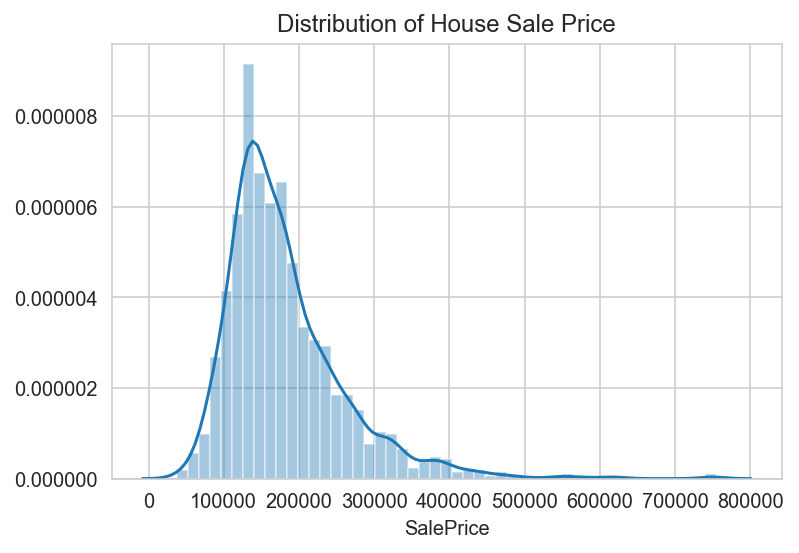

In [113]:
# check the distribution of house sale price

sns.distplot(house_clean['SalePrice']).set_title('Distribution of House Sale Price')

Text(0.5, 1.0, 'Box plot of House Sale Price')

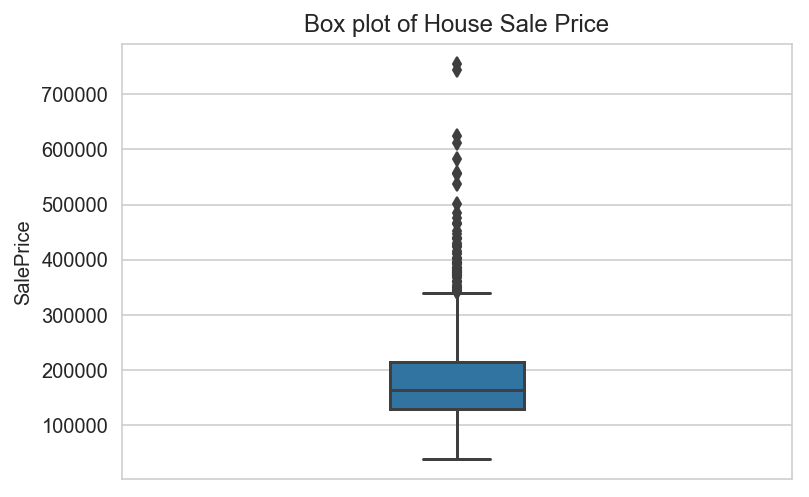

In [114]:
sns.boxplot(house_clean.SalePrice, orient='v', width = 0.2).set_title('Box plot of House Sale Price')
#house[['SalePrice']].boxplot()


In [115]:
# print(Outlier(house_clean[['SalePrice']]))

house_clean[house_clean['SalePrice'] > 700000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,555,0,7,2007,WD,Abnorml,745000


In [155]:
# Remove all properties that are greater than $700,000
house_clean = house_clean[house_clean.SalePrice < 700000]
house_clean.shape

(1442, 83)

## EDA on numerical variables

In [117]:
# Pick all numerical features

num_fts = []

for elem in house_clean.columns:
    #print(elem)
    if house_clean[elem].dtype == np.int64 or house_clean[elem].dtype == np.float64:
        num_fts.append(elem)
print('Numerical features : ', len(num_fts))
print('--------------------------------------------------------------------------')
print(num_fts)

Numerical features :  36
--------------------------------------------------------------------------
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [42]:
num_fts = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', 'BsmtFinSF1', 
           'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
           'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
           'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
           'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

### Correlation plot of numerical variables

In [ ]:
### First check correlation between numerical variables & check highly correlated variables

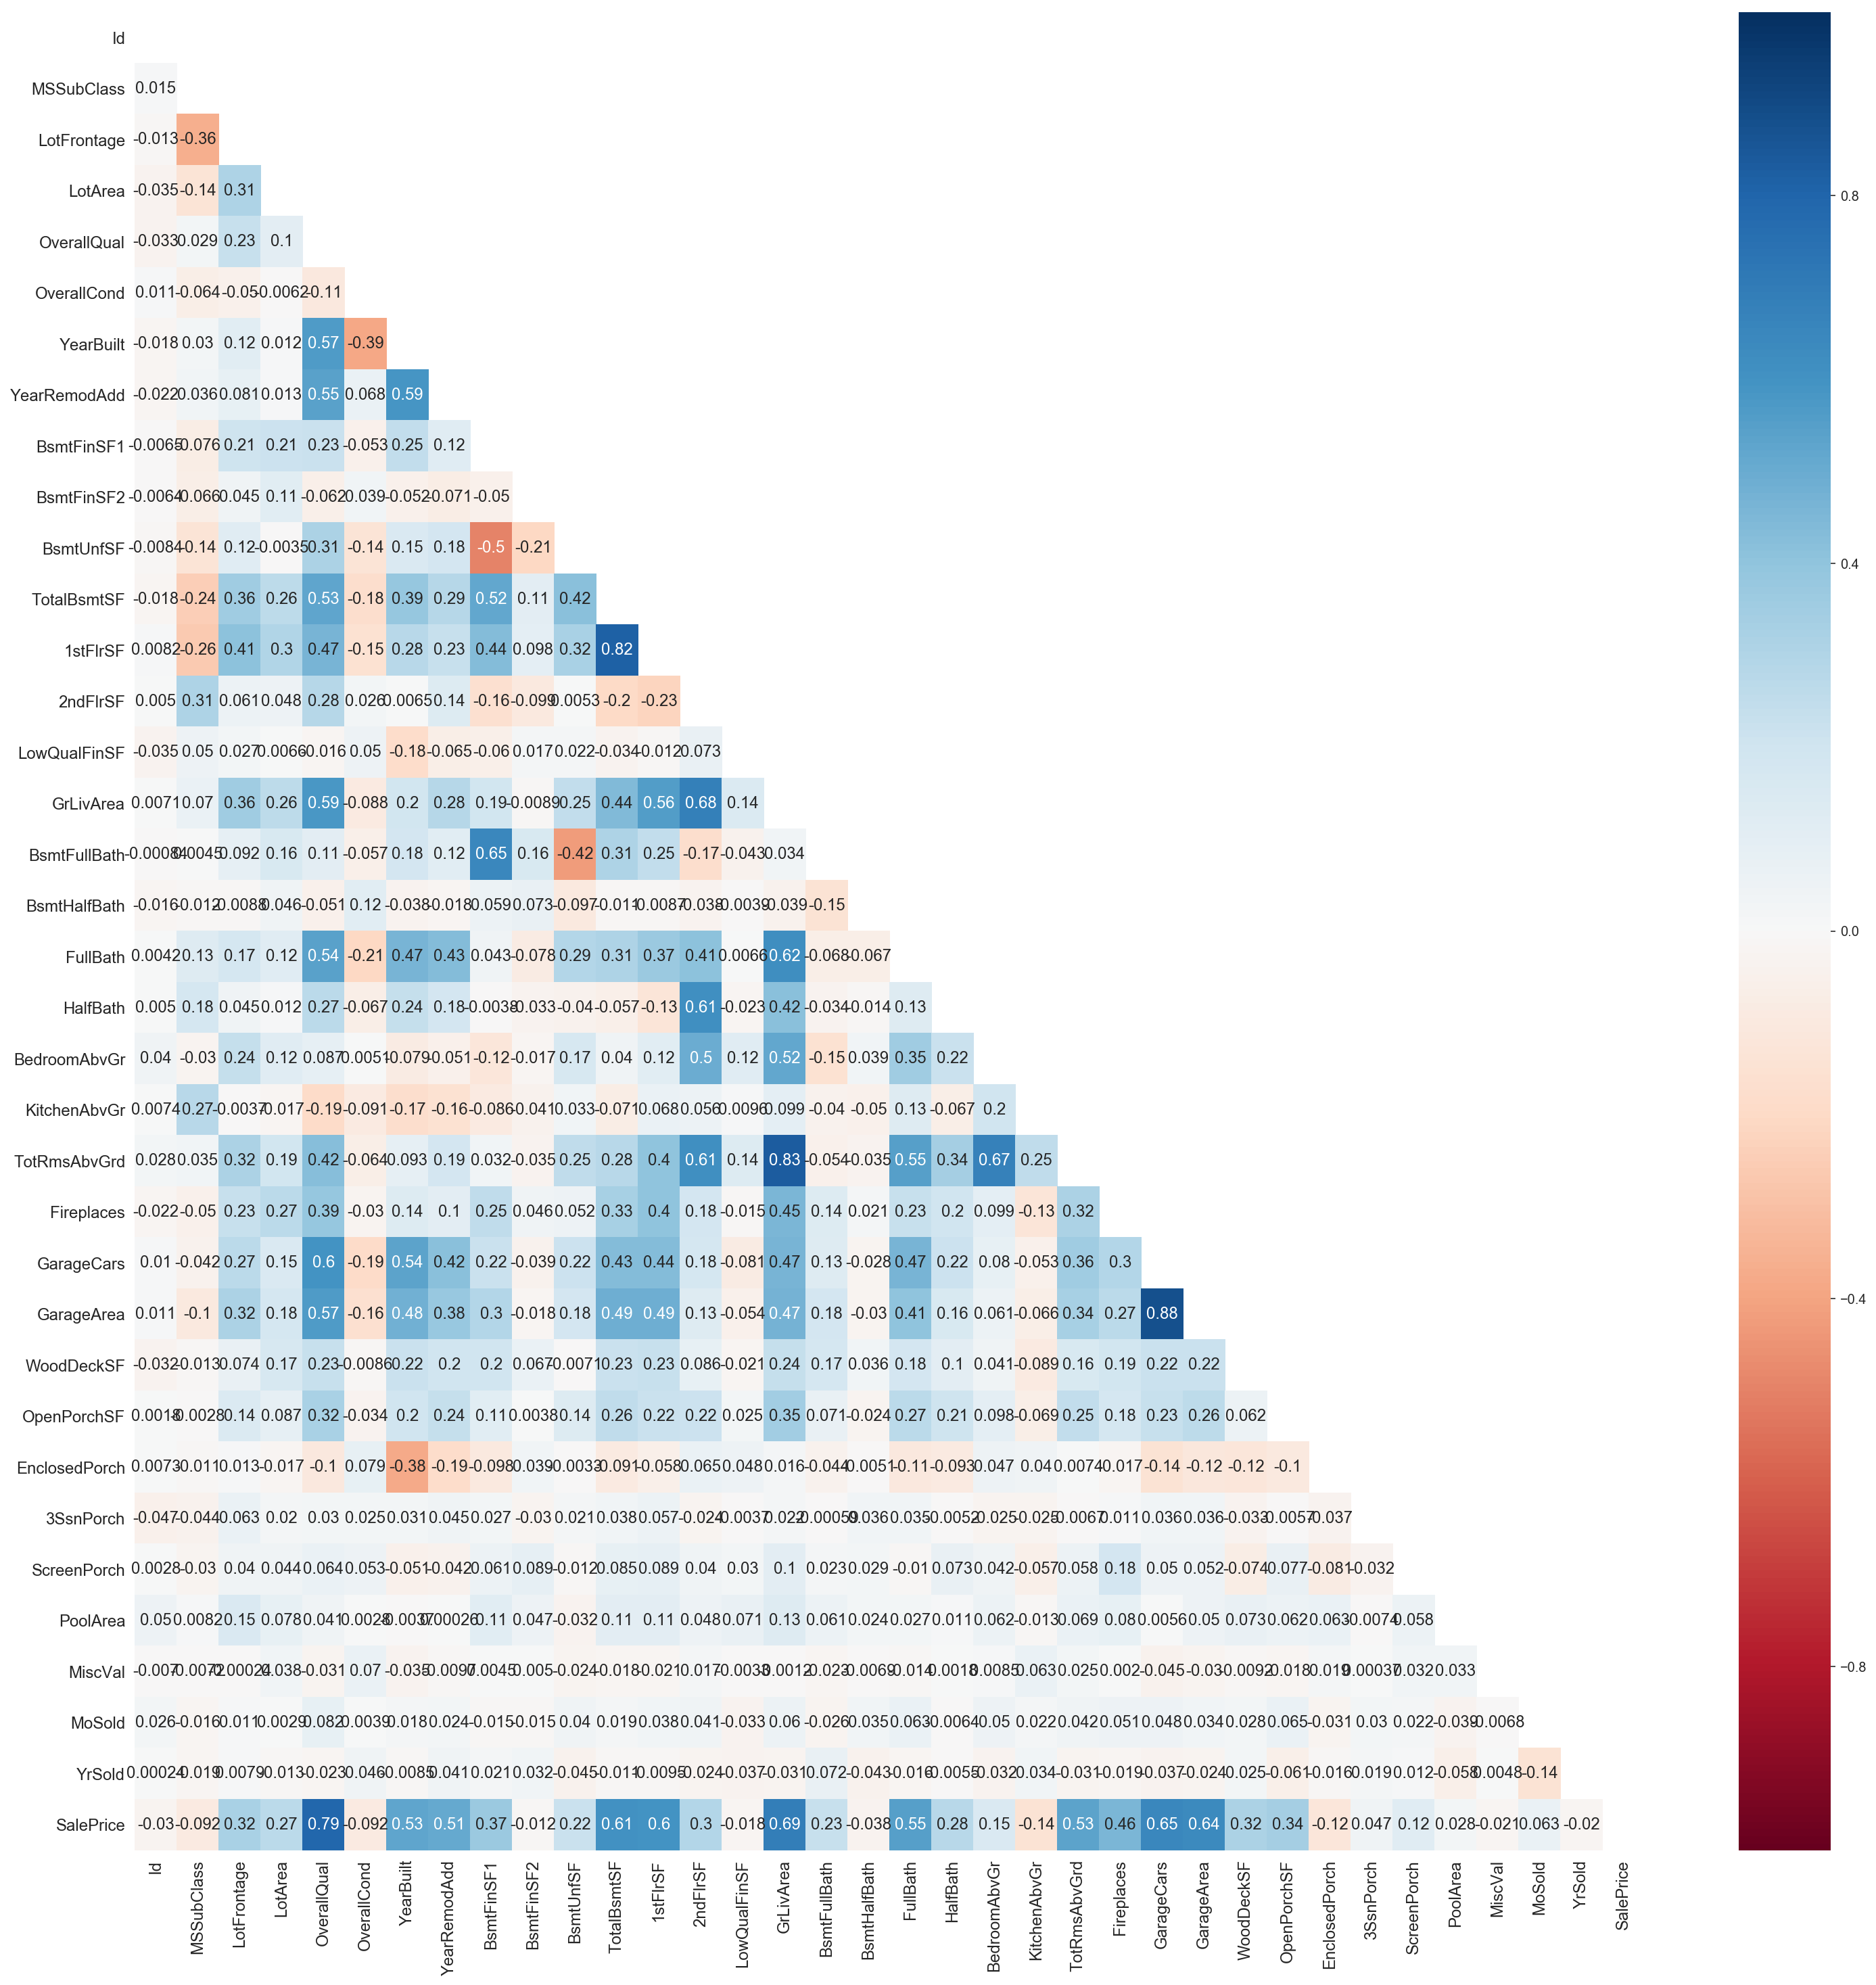

In [119]:
corr = house_clean[num_fts].corr()

fig, ax = plt.subplots(figsize=(25,25))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, ax=ax, cmap="RdBu",cbar=True,
                 annot=True,annot_kws={"size": 12},
                 vmin=-1, vmax=1)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)

plt.show()

In [121]:
# Find all variable pairs which have correlation greater than 0.5

dict = {}  # Initialised empty dictionary


# Iterate through all rows of correlation matrix
for i in range(len(num_fts)-2):
    
    values = []  # Initialise empty list
    
    # Iterate through all columns of correlation matrix
    for j in range(len(num_fts)-2):
        
        # We want to access only the upper half of the matrix
        upper = np.triu(corr)
        corr_value = upper[i][j]
        
        # If the correlation value is greater than 0.3, the column name is appended to the value list.
        if abs(corr_value) != 1 and abs(corr_value) > 0.3:
            #print(corr_value)
            
            values.append(corr.index[j])
            #values.append(corr_value)
            
            dict[corr.index[i]] = values

dict


{'MSSubClass': ['LotFrontage', '2ndFlrSF'],
 'LotFrontage': ['LotArea',
  'TotalBsmtSF',
  '1stFlrSF',
  'GrLivArea',
  'TotRmsAbvGrd',
  'GarageArea'],
 'OverallQual': ['YearBuilt',
  'YearRemodAdd',
  'BsmtUnfSF',
  'TotalBsmtSF',
  '1stFlrSF',
  'GrLivArea',
  'FullBath',
  'TotRmsAbvGrd',
  'Fireplaces',
  'GarageCars',
  'GarageArea',
  'OpenPorchSF'],
 'OverallCond': ['YearBuilt'],
 'YearBuilt': ['YearRemodAdd',
  'TotalBsmtSF',
  'FullBath',
  'GarageCars',
  'GarageArea',
  'EnclosedPorch'],
 'YearRemodAdd': ['FullBath', 'GarageCars', 'GarageArea'],
 'BsmtFinSF1': ['BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'BsmtFullBath'],
 'BsmtUnfSF': ['TotalBsmtSF', '1stFlrSF', 'BsmtFullBath'],
 'TotalBsmtSF': ['1stFlrSF',
  'GrLivArea',
  'BsmtFullBath',
  'FullBath',
  'Fireplaces',
  'GarageCars',
  'GarageArea'],
 '1stFlrSF': ['GrLivArea',
  'FullBath',
  'TotRmsAbvGrd',
  'Fireplaces',
  'GarageCars',
  'GarageArea'],
 '2ndFlrSF': ['GrLivArea',
  'FullBath',
  'HalfBath',
  'BedroomAbvGr'

### Examine numerical features that show high correlation (>0.3) with SalePrice.

In [120]:
# The features that show high correlation with SalePrice are:

num_high_corr = ['LotFrontage', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF','BsmtFinSF1', '1stFlrSF', 
                 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 
                 'WoodDeckSF', 'OpenPorchSF']


for elem in num_high_corr:
    print(house_clean[[elem, 'SalePrice']].corr())
    #print('Correlation between "', elem, '" and SalePrice" = ', house[[elem, 'SalePrice']].corr())
    print('-----------------------------------------------------------')

             LotFrontage  SalePrice
LotFrontage     1.000000   0.323565
SalePrice       0.323565   1.000000
-----------------------------------------------------------
           YearBuilt  SalePrice
YearBuilt   1.000000   0.529281
SalePrice   0.529281   1.000000
-----------------------------------------------------------
              YearRemodAdd  SalePrice
YearRemodAdd      1.000000   0.514908
SalePrice         0.514908   1.000000
-----------------------------------------------------------
             TotalBsmtSF  SalePrice
TotalBsmtSF     1.000000   0.607269
SalePrice       0.607269   1.000000
-----------------------------------------------------------
            BsmtFinSF1  SalePrice
BsmtFinSF1    1.000000   0.371311
SalePrice     0.371311   1.000000
-----------------------------------------------------------
           1stFlrSF  SalePrice
1stFlrSF   1.000000   0.596796
SalePrice  0.596796   1.000000
-----------------------------------------------------------
           GrLivAre

### Features that do not show high correlation with SalePrice.

We will remove:
[LotFrontage], [LotArea], [2ndFlrSF], [BsmtFullBath], [HalfBath], [BedroomAbvGr], [Fireplaces],
[WoodDeckSF], [OpenPorchSF], [EnclosedPorch], [MoSold], [YrSold]

### Features that are correlated to another.

We will remove:
    [1stFlrSF], [2ndFlrSF], [BedroomAbvGr], [TotRmsAbvGrd] <- we will use [GrLivArea]
    [GarageCars] <- we will use [GarageArea]

In [ ]:
# Now, the revised numerical feature looks like:

# num_fts_new = ['YearBuilt', 'YearRemodAdd', 'GrLivArea', 'FullBath', 'GarageArea', 'SalePrice']

In [ ]:
### Pairplot of Numerical Features vs SalePrice 

In [ ]:
### pairplot of sales vs revised numerical features

#fig, axes = plt.subplots(figsize=(15, 20))

#for i in range(len(num_fts)):
    #if num_fts[i] != 'SalePrice':
        
        #print('Correlation between "', num_fts[i], '" and SalePrice" : ')
        #print('')
        #print(house[[num_fts[i], 'SalePrice']].corr())
        #print('-----------------------------------------------------------')
        #house[[num_fts[i], 'SalePrice']].corr()
        #sns.jointplot(x = num_fts[i], y='SalePrice', data=house)
        
        
    #determine where the graph to be drawn
    #ax1 = int(i)//2
    #ax2 = int(i)%2
    
    #sns.jointplot(x=num_fts_new[i], y='SalePrice', data=house_fixed)

    #house[num_features_new[i]].plot(kind = 'hist', bins = 20, ax=axes[ax1][ax2]).set_title(num_features_new[i])

In [ ]:
#fig, axes = plt.subplots(7, 4, figsize=(24, 24))

#for i in range(len(num_features)):
        
    #determine where the graph to be drawn
    #ax1 = int(i)//4
    #ax2 = int(i)%4

    #sns.jointplot(x=house[num_features[i]], y=house['SalePrice'], ax=axes[ax1][ax2])

In [ ]:
### pairplot of sales vs numerical features (get correlation & p-values)
### remove outliers where necessary and re-plot (get correlation & p-values)

### New features? (Age of property/ combine house area?)

### LotFrontage vs SalePrice

house[['SalePrice', 'LotFrontage']].corr() = 0.34

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "LotFrontage" and "SalePrice" : 

             LotFrontage  SalePrice
LotFrontage     1.000000   0.340617
SalePrice       0.340617   1.000000
-----------------------------------------------------------


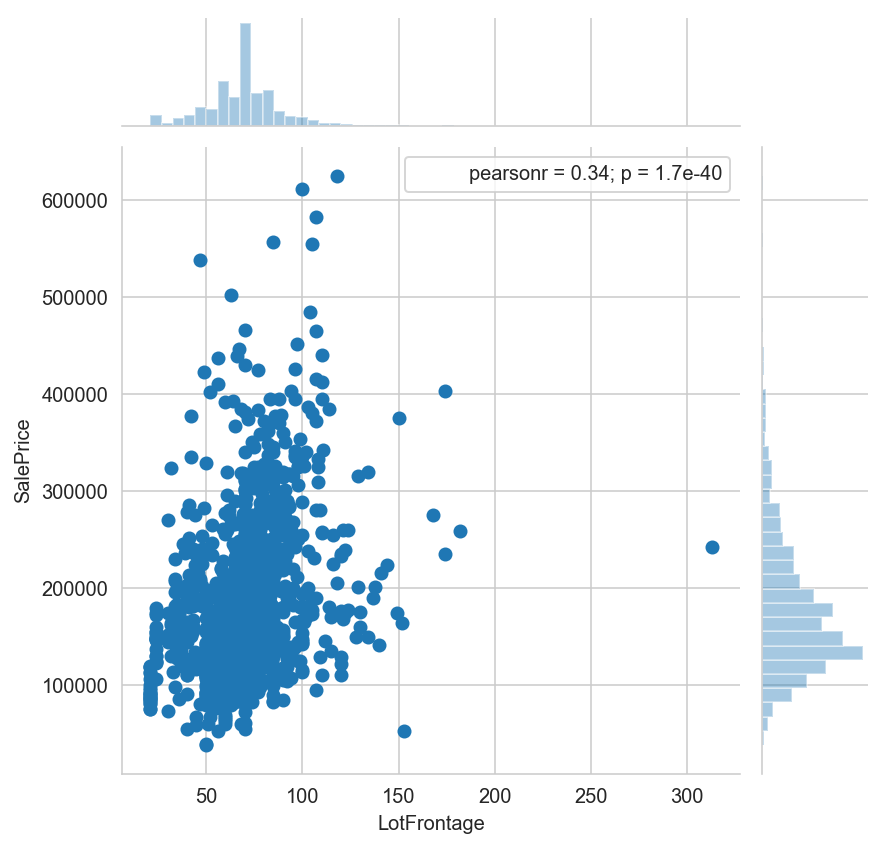

In [157]:
plot = sns.jointplot(x='LotFrontage',y='SalePrice', data=house_clean)
plot.annotate(stats.pearsonr)

print('Correlation between "LotFrontage" and "SalePrice" : ')
print('')
print(house_clean[['LotFrontage', 'SalePrice']].corr())
print('-----------------------------------------------------------')

In [162]:
house_clean[(house_clean['LotFrontage'] >= 300) | ((house_clean['LotFrontage'] >= 150) & (house_clean['SalePrice'] < 100000))]
house_clean = house_clean[~((house_clean['LotFrontage'] >= 300) | ((house_clean['LotFrontage'] >= 150) & (house_clean['SalePrice'] < 100000)))]

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "LotFrontage" and "SalePrice" : 

             LotFrontage  SalePrice
LotFrontage     1.000000   0.358546
SalePrice       0.358546   1.000000
-----------------------------------------------------------


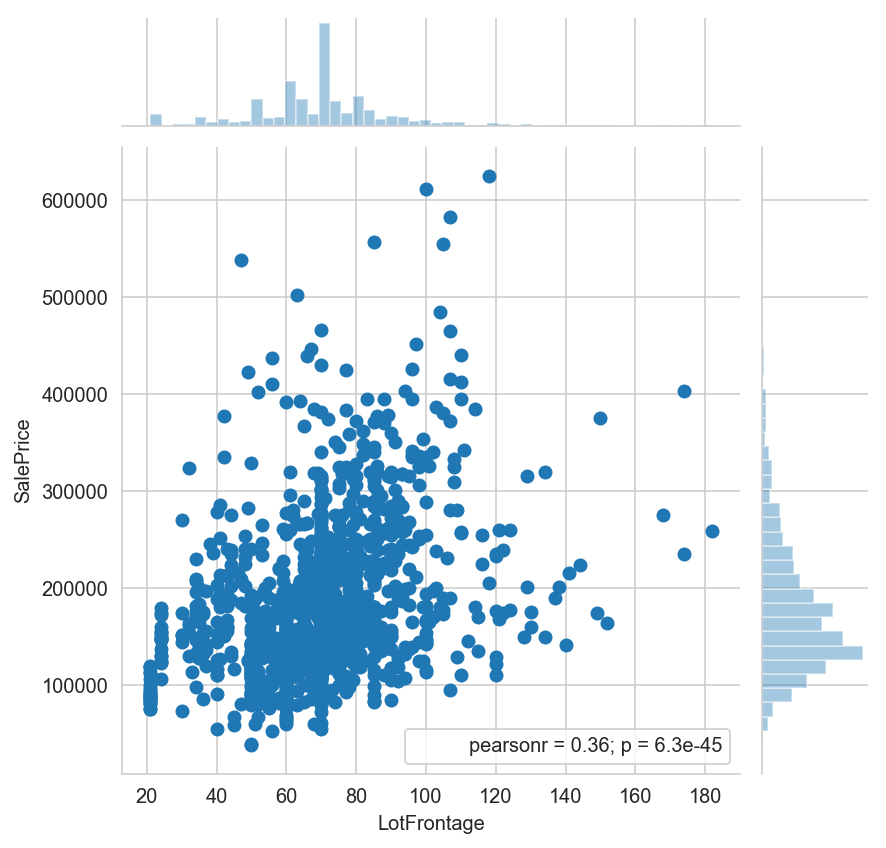

In [163]:
plot = sns.jointplot(x='LotFrontage',y='SalePrice', data=house_clean)
plot.annotate(stats.pearsonr)

print('Correlation between "LotFrontage" and "SalePrice" : ')
print('')
print(house_clean[['LotFrontage', 'SalePrice']].corr())
print('-----------------------------------------------------------')

### Property Age vs SalePrice

--------------------------------------------------------------------

house[['SalePrice', 'YearBuilt']].corr() = 0.55
house[['SalePrice', 'YearRemodAdd']].corr() = 0.52

house[['YearBuilt'] & ['YearRemodAdd']] = 0.6

--------------------------------------------------------------------

The 'YearBuilt' and 'YearRemodAdd' show good correlation with SalePrice. 
Those features also shows a relationship with each other.
Since 'year' is categorical, we will examine the number of years since the property was built.


#### Age of the property since first built

C:\Users\norik\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "PropAge" and "SalePrice" : 

            PropAge  SalePrice
PropAge    1.000000  -0.529453
SalePrice -0.529453   1.000000
-----------------------------------------------------------


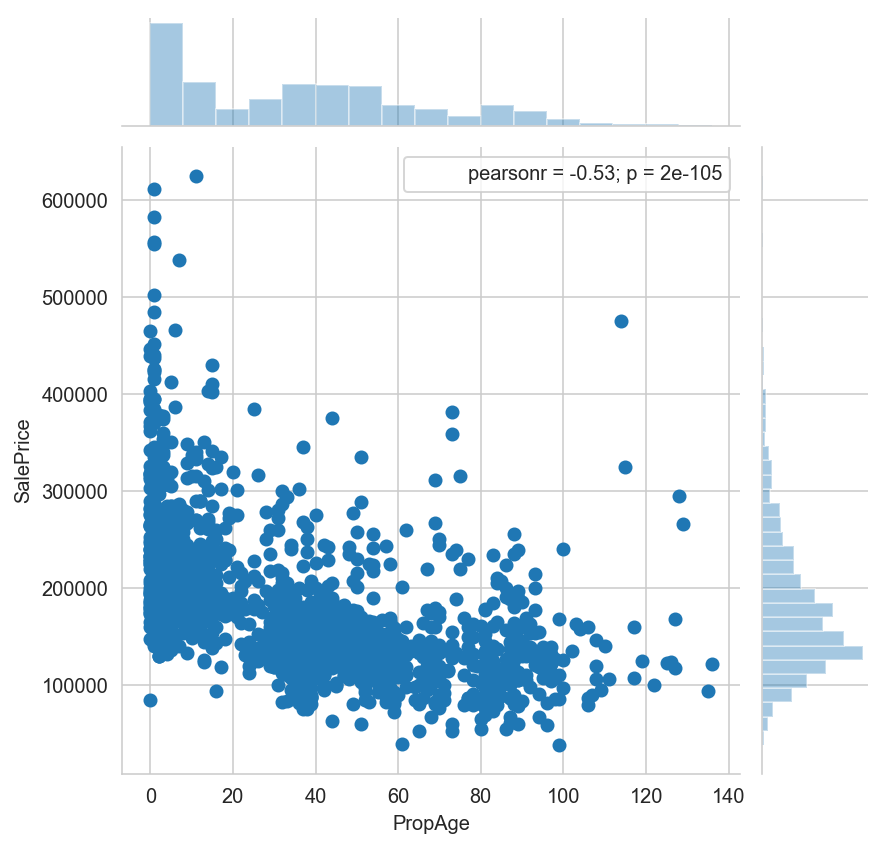

In [122]:
# Create a column with house age since first built
house_clean['PropAge']=house_clean.YrSold - house_clean.YearBuilt

plot = sns.jointplot(x='PropAge',y='SalePrice', data=house_clean)
plot.annotate(stats.pearsonr)

print('Correlation between "PropAge" and "SalePrice" : ')
print('')
print(house_clean[['PropAge', 'SalePrice']].corr())
print('-----------------------------------------------------------')

In [ ]:
# Check outliers for 'PropAge'
#print(Outlier(house[['PropAge']]))

# Identify properties whose Property Age is older than 125
# house[house['PropAge'] >= 125]

In [123]:
house_clean[(house_clean['PropAge'] >= 110) & (house_clean['SalePrice'] > 400000)]
house_clean = house_clean[~((house_clean['PropAge'] >= 110) & (house_clean['SalePrice'] > 400000))]

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "PropAge" and "SalePrice" : 

            PropAge  SalePrice
PropAge    1.000000  -0.540363
SalePrice -0.540363   1.000000
-----------------------------------------------------------


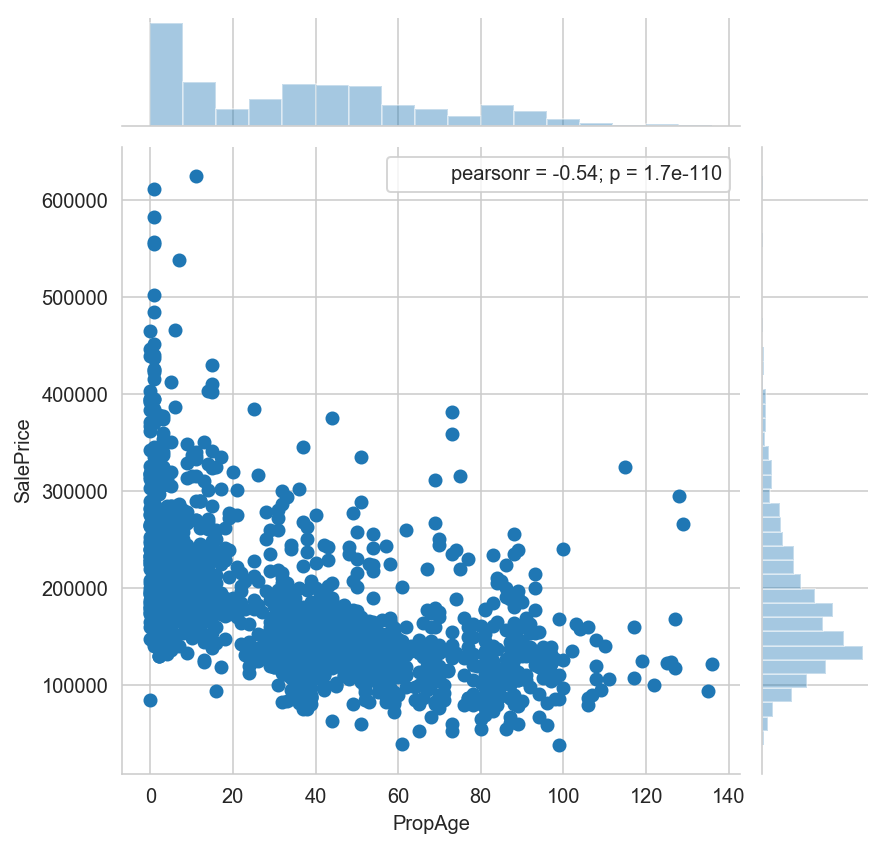

In [124]:
plot = sns.jointplot(x='PropAge', y='SalePrice', data=house_clean)
plot.annotate(stats.pearsonr)

print('Correlation between "PropAge" and "SalePrice" : ')
print('')
print(house_clean[['PropAge', 'SalePrice']].corr())
print('-----------------------------------------------------------')

#### Age of the property since remodelled

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "PropRemAge" and "SalePrice" : 

            PropRemAge  SalePrice
PropRemAge    1.000000  -0.517926
SalePrice    -0.517926   1.000000
-----------------------------------------------------------


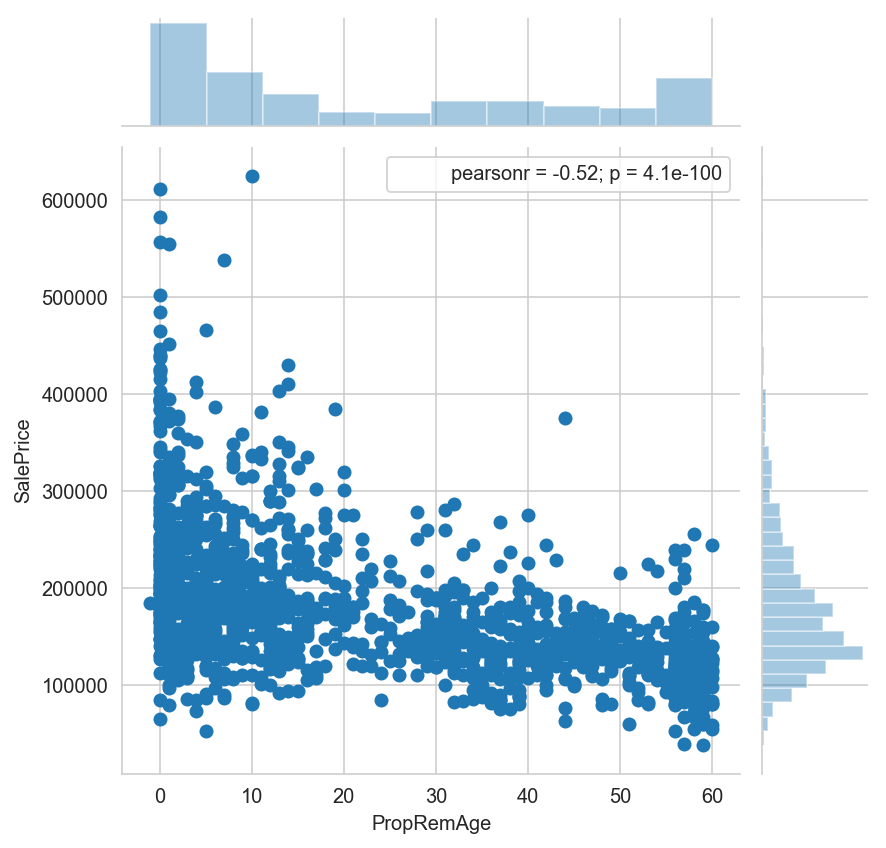

In [125]:
# Create a column with house age since remodelled
house_clean['PropRemAge']=house_clean.YrSold - house_clean.YearRemodAdd

plot = sns.jointplot(x='PropRemAge', y='SalePrice', data=house_clean)
plot.annotate(stats.pearsonr)

print('Correlation between "PropRemAge" and "SalePrice" : ')
print('')
print(house_clean[['PropRemAge', 'SalePrice']].corr())
print('-----------------------------------------------------------')

In [ ]:
# Check outliers for 'PropRemAge'
# print(Outlier(house[['PropRemAge']]))

### FloorSpace vs SalePrice

--------------------------------------------------------------------

house[['SalePrice', 'TotalBsmtSF']].corr() = 0.65
house[['SalePrice', '1stFlrSF']].corr() = 0.63

house[['TotalBsmtSF'] & ['1stFlrSF']] = 0.8


--------------------------------------------------------------------

house[['SalePrice', 'GrLivArea']].corr() = 0.72
house[['SalePrice', 'TotRmsAbvGrd']].corr() = 0.54

house[['GrlivArea'] & ['TotalRmsAbvGnd']] = 0.83

--------------------------------------------------------------------

house[['SalePrice', 'GarageCars']].corr() = 0.65
house[['SalePrice', 'GarageArea']].corr() = 0.64


house[['GarageCars'] & ['GarageArea']] = 0.89

---------------------------------------------------------------------


Those features are indicators of floor area, so we will combine all the area indicators in the data and re-examine the correlation with the SalePrice.

#### Combine 'GrLivArea', 'TotalBsmtSF' and see if it gives better correlation with "SalePrice"

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "TotalHomeArea" and "SalePrice" : 

               TotalHomeArea  SalePrice
TotalHomeArea       1.000000   0.768016
SalePrice           0.768016   1.000000
-----------------------------------------------------------


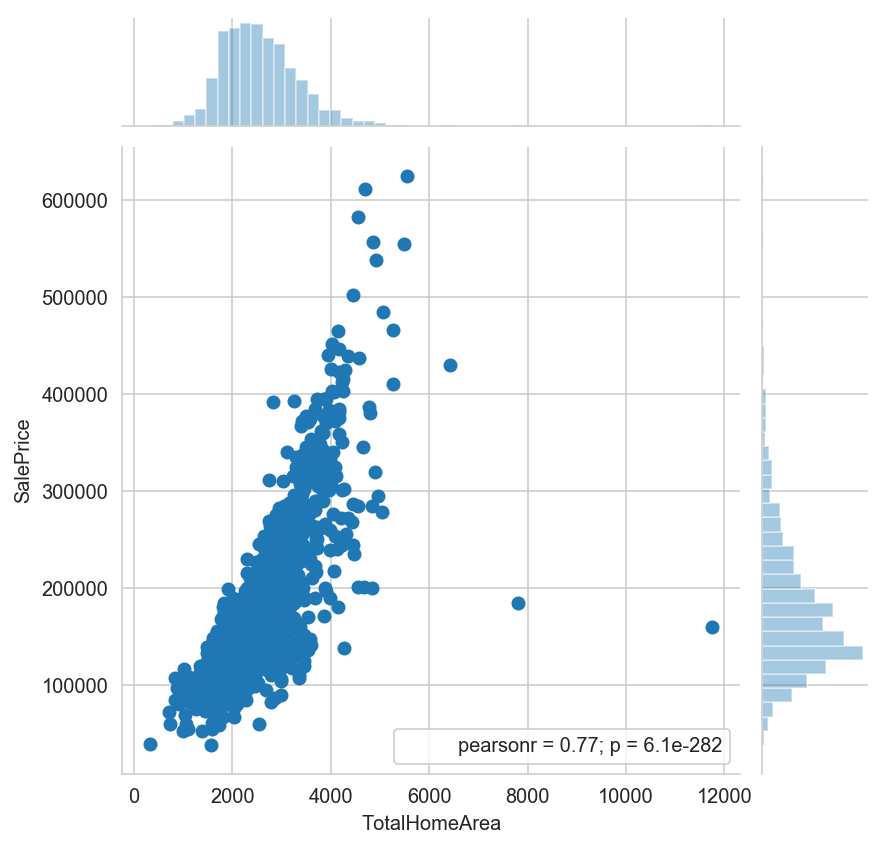

In [126]:
# Create a column with above grond and basement areas combined
house_clean['TotalHomeArea'] = house_clean.GrLivArea + house_clean.TotalBsmtSF

plot = sns.jointplot(x='TotalHomeArea',y='SalePrice', data=house_clean)
plot.annotate(stats.pearsonr)

print('Correlation between "TotalHomeArea" and "SalePrice" : ')
print('')
print(house_clean[['TotalHomeArea', 'SalePrice']].corr())
print('-----------------------------------------------------------')

#### Combine 'GrLivArea', 'TotalBsmtSF', 'GarageArea' and see if it gives better correlation with "SalePrice"

Correlation between "TotalArea" and "SalePrice" : 

           TotalArea  SalePrice
TotalArea   1.000000   0.800703
SalePrice   0.800703   1.000000
-----------------------------------------------------------


C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


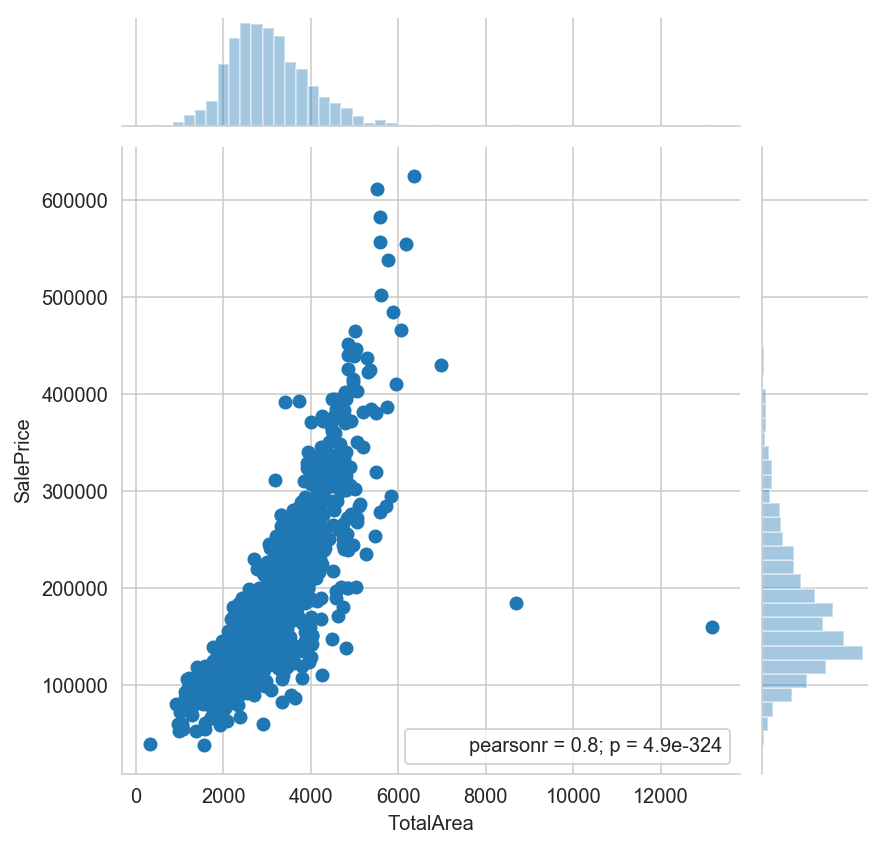

In [127]:
# Create a column with above grond, basement & garage areas combined
house_clean['TotalArea'] = house_clean.GrLivArea + house_clean.TotalBsmtSF + house_clean.GarageArea

plot = sns.jointplot(x='TotalArea',y='SalePrice', data=house_clean)
plot.annotate(stats.pearsonr)

print('Correlation between "TotalArea" and "SalePrice" : ')
print('')
print(house_clean[['TotalArea', 'SalePrice']].corr())
print('-----------------------------------------------------------')

In [128]:
# There are two properties that have greater than 8000 sf @ low price. These are outliers, so we remove them.

house_clean[house_clean['TotalArea'] >= 8000]
house_clean = house_clean[house_clean.TotalArea < 8000]

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "TotalArea" and "SalePrice" : 

           TotalArea  SalePrice
TotalArea   1.000000   0.848216
SalePrice   0.848216   1.000000
-----------------------------------------------------------


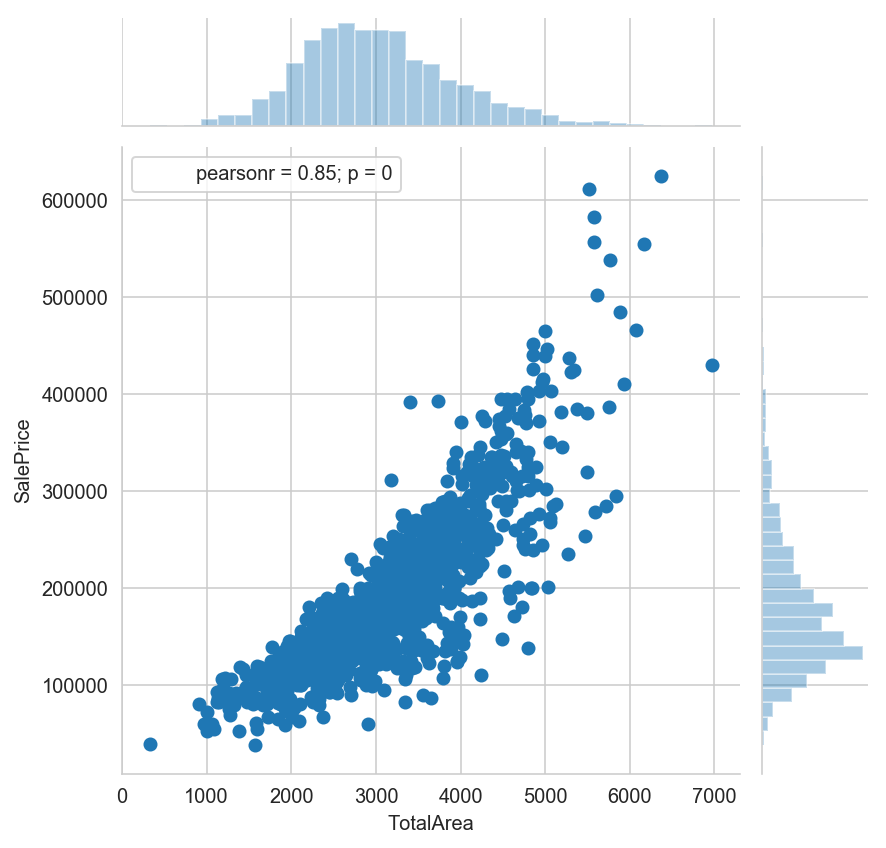

In [129]:
house_clean['TotalArea'] = house_clean.GrLivArea + house_clean.TotalBsmtSF + house_clean.GarageArea

plot = sns.jointplot(x='TotalArea',y='SalePrice', data=house_clean)
plot.annotate(stats.pearsonr)

print('Correlation between "TotalArea" and "SalePrice" : ')
print('')
print(house_clean[['TotalArea', 'SalePrice']].corr())
print('-----------------------------------------------------------')

### Bathrooms vs SalePrice

house[['SalePrice', 'FullBath']].corr() = 0.56

We will count the number of bathrooms and re-examine the correlation with the SalePrice.

#### Combine number of bathrooms and see if it gives better correlation with "SalePrice" compared to "FullBath" count only

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "TotalBath" and "SalePrice" : 

           TotalBath  SalePrice
TotalBath   1.000000   0.611334
SalePrice   0.611334   1.000000
-----------------------------------------------------------


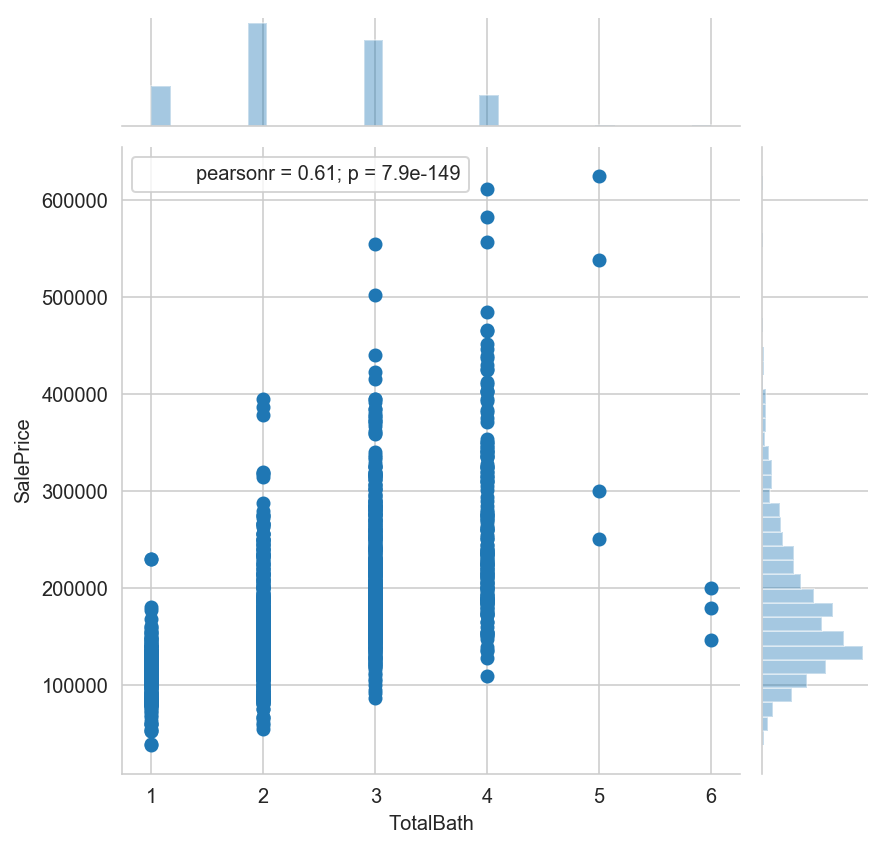

In [130]:
# Create a column with all bathrooms combined
house_clean['TotalBath'] = house_clean.BsmtFullBath + house_clean.BsmtHalfBath + house_clean.FullBath + house_clean.HalfBath

plot = sns.jointplot(x='TotalBath',y='SalePrice', data=house_clean)
plot.annotate(stats.pearsonr)

print('Correlation between "TotalBath" and "SalePrice" : ')
print('')
print(house_clean[['TotalBath', 'SalePrice']].corr())
print('-----------------------------------------------------------')

In [131]:
# There are properties with 6 bathrooms @ low price. These are outliers, so we remove them.

house_clean[house_clean['TotalBath'] == 6]
house_clean = house_clean[house_clean.TotalBath != 6]

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "TotalBath" and "SalePrice" : 

           TotalBath  SalePrice
TotalBath   1.000000   0.622022
SalePrice   0.622022   1.000000
-----------------------------------------------------------


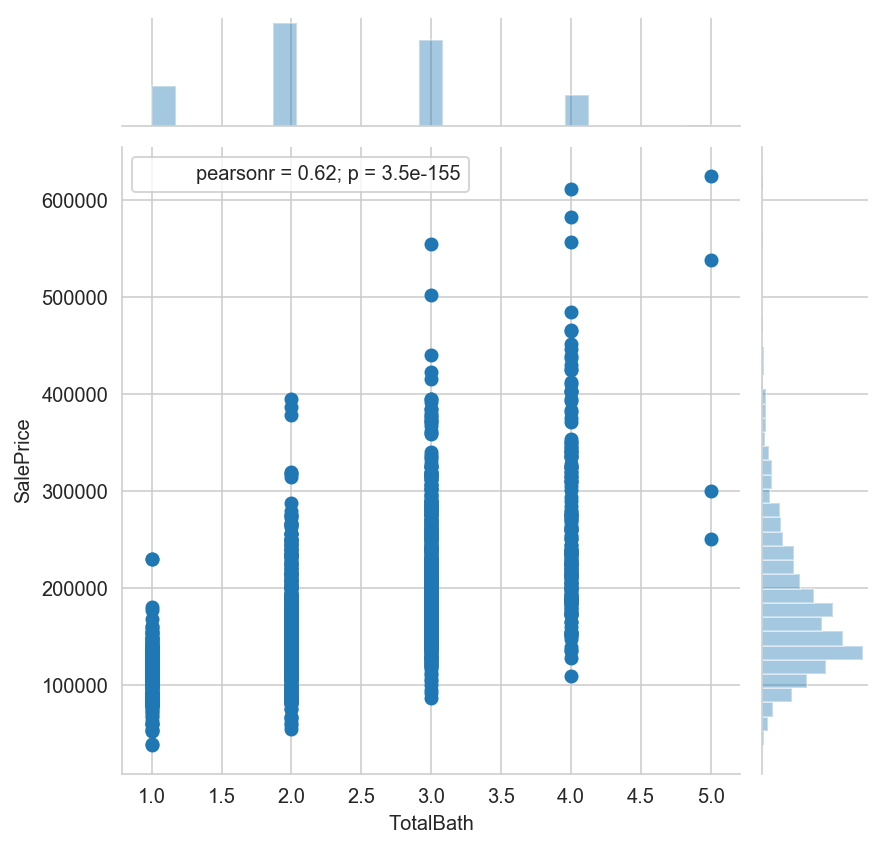

In [57]:
house_clean['TotalBath'] = house_clean.BsmtFullBath + house_clean.BsmtHalfBath + house_clean.FullBath + house_clean.HalfBath

plot = sns.jointplot(x='TotalBath',y='SalePrice', data=house_clean)
plot.annotate(stats.pearsonr)

print('Correlation between "TotalBath" and "SalePrice" : ')
print('')
print(house_clean[['TotalBath', 'SalePrice']].corr())
print('-----------------------------------------------------------')

#### Combine all Porches and see if it gives better correlation with "SalePrice"

house[['SalePrice', 'OpenPorch']].corr() = 0.32

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "TotalPorch" and "SalePrice" : 

            TotalPorch  SalePrice
TotalPorch     1.00000    0.39744
SalePrice      0.39744    1.00000
-----------------------------------------------------------


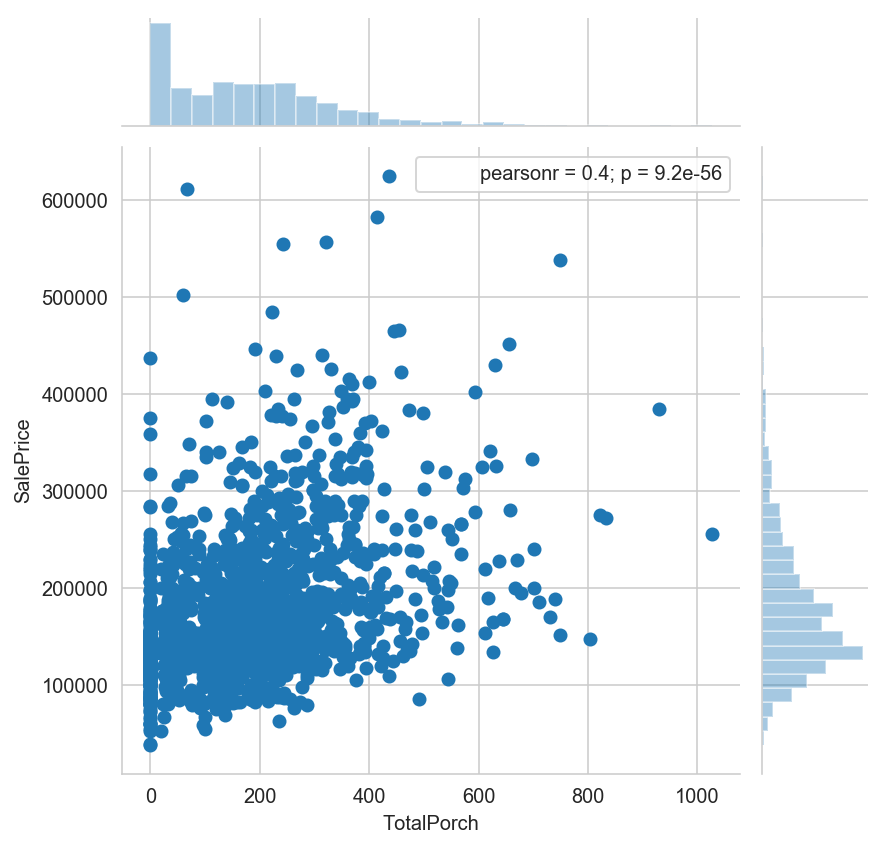

In [132]:
# Create a column with total porch areas including WoodDeck
house_clean['TotalPorch'] = house_clean.WoodDeckSF + house_clean.OpenPorchSF + house_clean.EnclosedPorch + house_clean['3SsnPorch'] + house_clean.ScreenPorch
#house_clean['TotalPorch'] = house_clean.OpenPorchSF + house_clean.EnclosedPorch

plot = sns.jointplot(x='TotalPorch',y='SalePrice', data=house_clean)
plot.annotate(stats.pearsonr)

print('Correlation between "TotalPorch" and "SalePrice" : ')
print('')
print(house_clean[['TotalPorch', 'SalePrice']].corr())
print('-----------------------------------------------------------')

In [ ]:
# From the EDA on numerical 

In [ ]:
# Then, draw histograms for each feature we want to use
# Check correlation between continuous variables and remove highly correlated var
# Identify outliers and see if we want to remove them
# Check some columns do not have many values in the cells. May want to drop the columns?
# Examine categorical variables via drawing plot vs SalePrice
# Remove bad categorical variables
# Built year? What to do with them?




In [59]:
# Examining the scatter plots, we will remove the variables that appear to have no relationship with the SalePrice.
# We will also remove the variables that are correlated to another variable. (Ex. BdrmAbvGr and TotRmsAbvGrd)

num_features_new = ['LotFrontage', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea', 'WoodDeckSF']

In [ ]:
#fig, axes = plt.subplots(5, 2, figsize=(15, 20))

#for i in range(len(num_features_new)):
        
    #determine where the graph to be drawn
    #ax1 = int(i)//2
    #ax2 = int(i)%2

    #house[num_features_new[i]].plot(kind = 'hist', bins = 20, ax=axes[ax1][ax2]).set_title(num_features_new[i])

In [ ]:
# ALSO REMOVE NON_FIXED FEATURES!!

#  MasVnrArea - not removing any
#  TotalBsmtSF - not removing any
#  2ndFlrArea  - not a good estimator..

# Do the othe ones which we constructed the histplot for


From the plots, 'MasVnrArea', '2ndFlrSF', 'WoodDeckSF' do not appear to be good predictors. 
For the remaining numerical features, we will check the outliers.  

Remaining numerical fetures are:
['LotFrontage', 'LotArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea']

#### Outlier for 'LotFrontage'

In [ ]:
# Check outlier for 'LotFrontage'
#print(Outlier(house[['LotFrontage']]))

# Identify properties whose LotFrontage are larger than 150
#house[house['LotFrontage'] > 150]

#### Outlier for 'LotArea'

In [ ]:
# Check outlier for 'LotArea'
#print(Outlier(house[['LotArea']]))

# Identify properties whose LotArea are larger than 50,000
#house[house['LotArea'] > 50000]

#house = house[house['LotArea'] < 50000]
#house = house[house['LotArea'] < 50000]

#### Outlier for 'TotalBsmtSF'

In [ ]:
# Check outlier for 'TotalBsmtSF'
#print(Outlier(house[['TotalBsmtSF']]))

# Identify properties whose TotalBsmtSF are larger than 50,000
#house[house['TotalBsmtSF'] > 3000]

In [ ]:
#['LotFrontage', 'LotArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea']

#### Outlier for '1stFlrSF'

In [ ]:
# Check outlier for 'TotalBsmtSF'
#print(Outlier(house[['1stFlrSF']]))

# Identify properties whose TotalBsmtSF are larger than 50,000
#house[house['1stFlrSF'] > 2500]

#### Outlier for GrLivArea'

In [ ]:
# Check outlier for GrLivArea'
# print(Outlier(house[['GrLivArea']]))

# Identify properties whose TotalBsmtSF are larger than 50,000
# house[house['GrLivArea'] > 3500]

#### Outlier for 'TotRmsAbvGrd'

In [ ]:
# Check outlier for 'TotRmsAbvGrd'
# print(Outlier(house[['TotRmsAbvGrd']]))

# Identify properties whose TotalBsmtSF are larger than 50,000
# house[house['TotRmsAbvGrd'] > ]

#### Outlier for 'GarageArea'

In [ ]:
# Check outlier for 'GarageArea
# print(Outlier(house[['GarageArea']]))

# Identify properties whose TotalBsmtSF are larger than 50,000
# house[house['GarageArea'] > ]

In [ ]:
#categorical_features = []

#for elem in house.columns:
    #if elem not in num_features:
        #categorical_features.append(elem)

In [ ]:
#print('There are ', len(categorical_features), ' categorical variables.')
#print('A list of categorical variables: ')
#print(categorical_features)

In [ ]:
# Scatter plot all features against sale prices
# Check for any correlation

# Set up plot area
#fig, axes = plt.subplots(4, 4, figsize=(16,20))

##########################################################
#for item in house.columns:
    #if item != 'Id'
    #print(item)
    #plot = sns.pairplot(house, x_vars=[item], y_vars=['SalePrice'])
    #plt.scatter(house[item], house['SalePrice'])


In [ ]:
# Check values in each categorical features


#print( 'Bld Class: ', house.MSSubClass.unique())
#print('Zone Class: ', house.MSZoning.unique())
#print('Street: ', house.Street.unique())
#print('Alley: ', house.Alley.unique())
#print('Shape of Property: ', house.LotShape.unique())
#print('Flatness of Property: ', house.LandContour.unique())
#print('Avail Utilities: ', house.Utilities.unique())
#print('BldgType: ', house.BldgType.unique())
#print('HouseStyle: ', house.HouseStyle.unique())

In [ ]:
plt.scatter(pd.to_numeric(house[~(house['LotFrontage']=='No_Frontage')]['LotFrontage']),np.lophouse[~(house['LotFrontage']=='No_Frontage')]['SalePrice'])

## EDA on Categorical Features

In [133]:
# Create a list of categorical variables

num_fts = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', 'BsmtFinSF1', 
           'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
           'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
           'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
           'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


# Initialise categorical feature list
cat_fts = []

for elem in house_clean.columns:
    if elem not in num_fts:
        cat_fts.append(elem)

print(cat_fts)
print('----------------------------------------------------------------------------------------------------------------------')
print(house_clean[cat_fts].dtypes)

['Id', 'MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition', 'PropAge', 'PropRemAge', 'TotalHomeArea', 'TotalArea', 'TotalBath', 'TotalPorch']
----------------------------------------------------------------------------------------------------------------------
Id                int64
MSSubClass        int64
MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandS

In [134]:
# remove some non-categorical features

non_cat = ['Id', 'MSSubClass', 'GarageYrBlt', 'PropAge', 'PropRemAge', 'TotalBath', 'TotalPorch', 'TotalHomeArea', 'TotalArea']

for elem in non_cat:
    if elem in cat_fts:
        cat_fts.remove(elem)

cat_fts.append('SalePrice')    
print('Categorical features : ', len(cat_fts))
print('--------------------------------------------------------------------------')
print(cat_fts)

Categorical features :  42
--------------------------------------------------------------------------
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition', 'SalePrice']


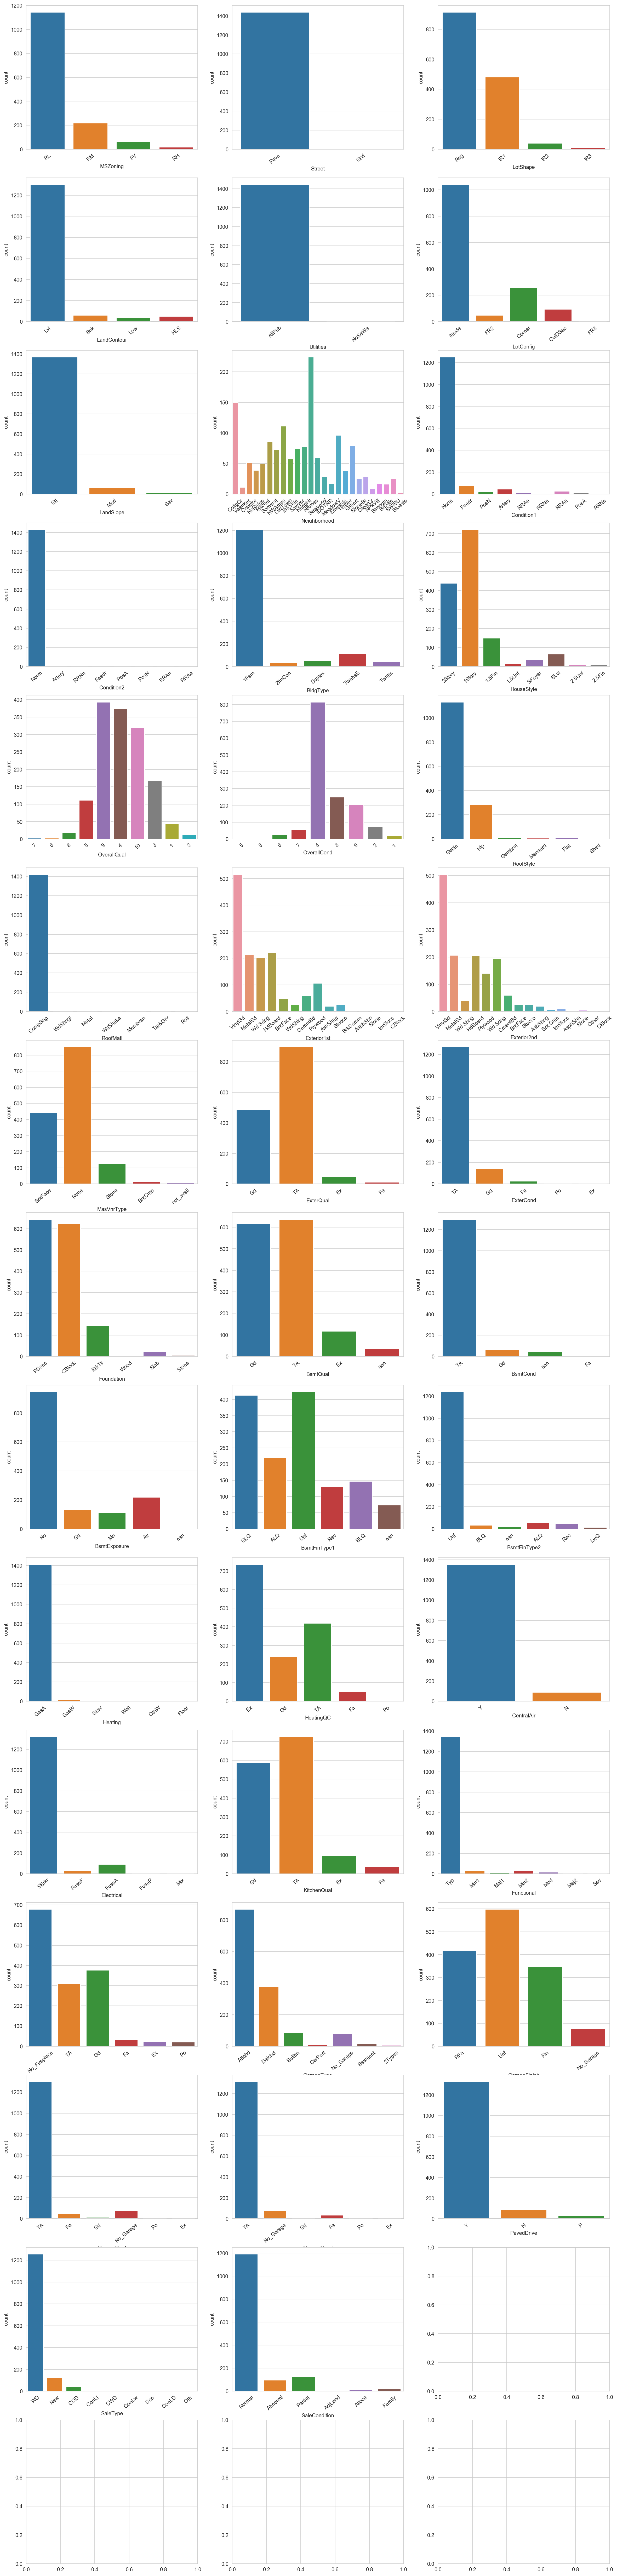

In [135]:
fig, axes = plt.subplots(15, 3, figsize = (20,90))

for i in range(len(cat_fts)):
    if cat_fts[i] != 'SalePrice':
        
        #determine where the graph to be drawn
        ax1 = int(i)//3
        ax2 = int(i)%3
        
        sns.countplot(x = cat_fts[i], data=house_clean, ax=axes[ax1][ax2]).set_xticklabels(labels = house_clean[cat_fts[i]].unique(), rotation=40, fontdict = {'fontsize': 10})
        
    #print('Correlation between "', num_fts[i], '" and SalePrice" : ')
    #print('')
    #print(house[[num_fts[i], 'SalePrice']].corr())
    #print('-----------------------------------------------------------')
    #house[[num_fts[i], 'SalePrice']].corr()


In [ ]:
# From the countplot above, we can see 'Neighborhood, 'OverallQual', 'Exterior1st', 'Exterior2nd', 'BsmtFinType1' appear to be
#  usable features.

# We will further examine those usable fetures against SalePrice

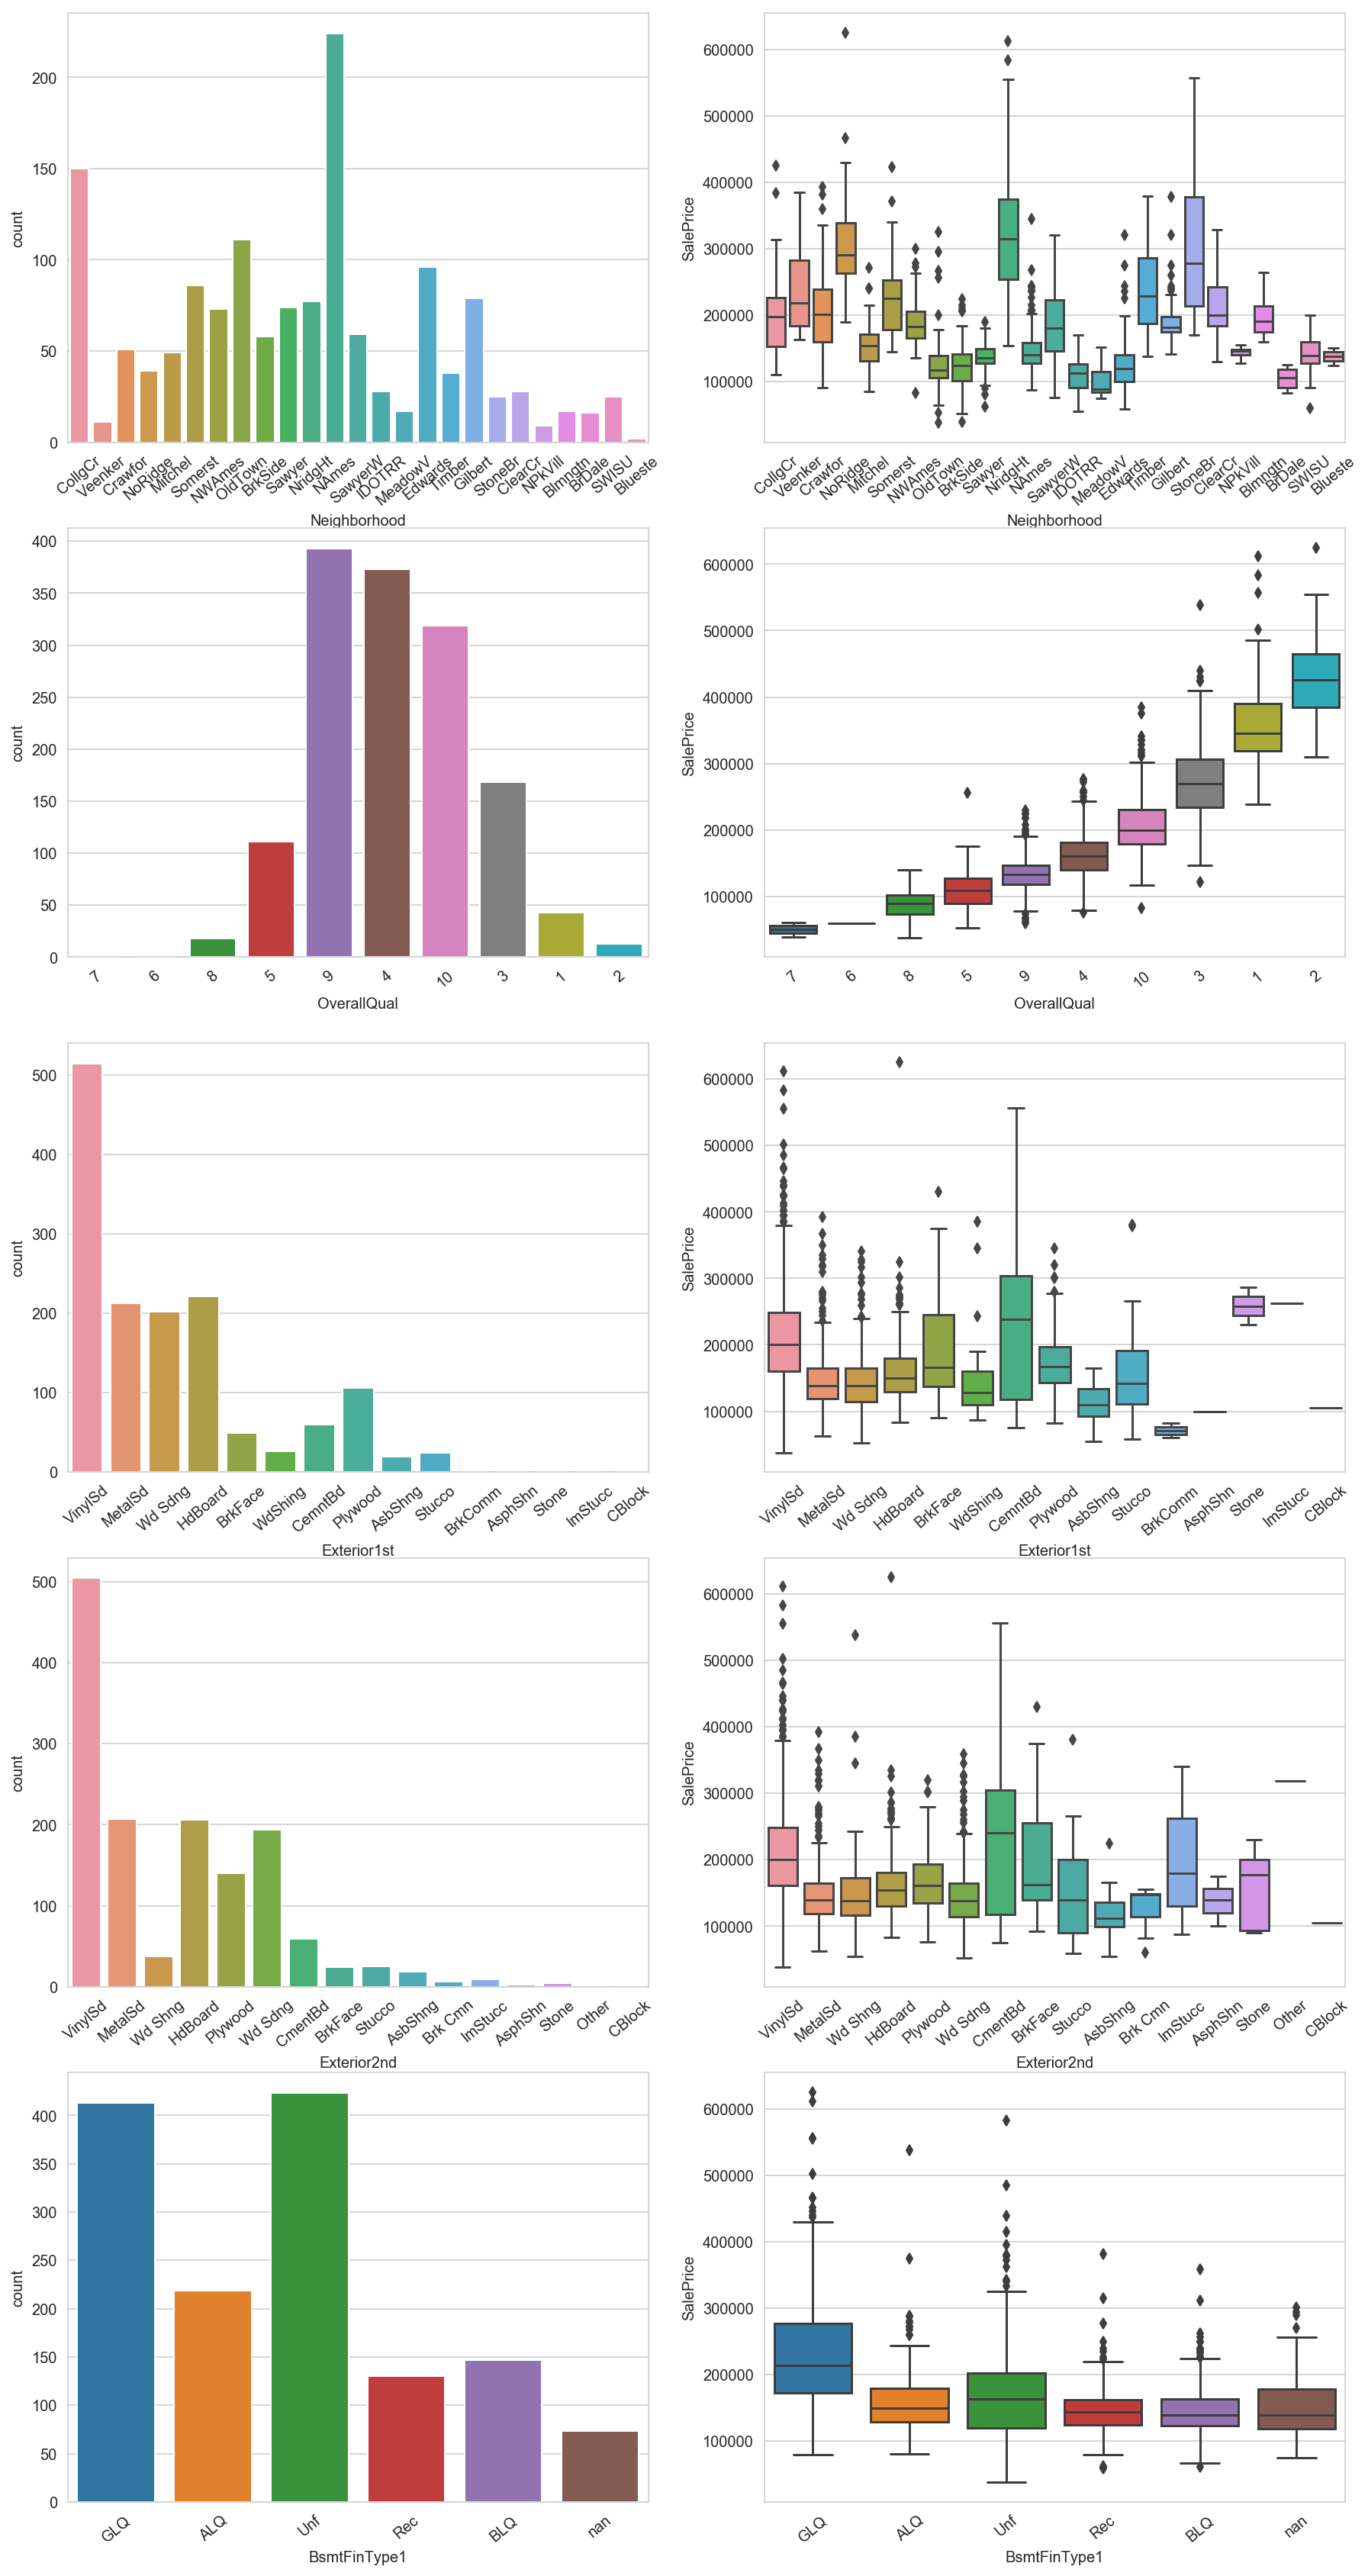

In [136]:
cat_fts_gd = ['Neighborhood', 'OverallQual', 'Exterior1st', 'Exterior2nd', 'BsmtFinType1']
    
fig, axes = plt.subplots(5, 2, figsize = (15,30))

for i in range(len(cat_fts_gd)):
    #print(cat_fts_gd[i])
    
        
    #determine where the graph to be drawn
    
    
    
    countplot = sns.countplot(data = house_clean, x = cat_fts_gd[i], ax=axes[i][0])
    countplot.set_xticklabels(labels = house_clean[cat_fts_gd[i]].unique(), rotation=40, fontdict = {'fontsize': 10})
    
    boxplot = sns.boxplot(data = house_clean, x = cat_fts_gd[i], y = 'SalePrice', ax=axes[i][1])
    boxplot.set_xticklabels(labels = house_clean[cat_fts_gd[i]].unique(), rotation=40, fontdict = {'fontsize': 10})



In [ ]:
# Check the outliers 

In [ ]:
# Check correlation between categories using chi-squared??

In [137]:
house_clean.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

In [164]:
# Following the EDA on the variables, we will drop some 

#fixed_fts_gd = ['LotFrontage', 'PropAge', 'TotalArea', 'TotalBath' ]

fixed_fts_gd = ['PropAge', 'TotalArea', 'TotalBath' ]

In [165]:
house_fixed = house_clean[fixed_fts_gd]
house_fixed.shape
house_fixed.dtypes

PropAge      int64
TotalArea    int64
TotalBath    int64
dtype: object

In [ ]:
# Change MSSubclass from integer to object

#fixed_house.MSSubClass = fixed_house.MSSubClass.astype(str)

In [ ]:
# Dummify all the categorical data

#fixed_house = pd.get_dummies(fixed_house, drop_first=True) 
#fixed_house.shape

In [ ]:
#fixed_house.head()

In [ ]:
#fixed_house.columns

In [ ]:
#fixed_house['MSZoning_RH'].unique()

In [166]:
house_fixed.head()

,PropAge,TotalArea,TotalBath
0,5,3114,4
1,31,2984,3
2,7,3314,4
3,91,3115,2
4,8,4179,4


## Train & Test Model with 'PropAge',  'TotalArea', 'TotalBath' for all Neighborhood

In this section, we will use only the variables that appear to be relevant after performing EDA. 
We will perform feature selection using Sci-Kit Learn in the next section and compare the results to ensure the chosen features produce an optimised model.

In [197]:
# Train model on pre-2010 model and test with 2010 data

fixed_pre2010 = house_fixed[house_clean.YrSold<2010]
fixed_pre2010.isnull().sum()

PropAge      0
TotalArea    0
TotalBath    0
dtype: int64

In [198]:
# Check how many test data points

fixed_post2010 = house_fixed[house_clean.YrSold>2009]
fixed_post2010.shape

(172, 3)

In [199]:
# Create a dataframe for dependent variable, SalePrice
SalePrice_pre2010 = house_clean['SalePrice'][house_clean.YrSold<2010]
SalePrice_post2010 = house_clean['SalePrice'][house_clean.YrSold>2009]

# SalePrice_pre2010

In [170]:
fixed_pre2010

,PropAge,TotalArea,TotalBath
0,5,3114,4
1,31,2984,3
2,7,3314,4
3,91,3115,2
4,8,4179,4
5,16,2638,3
6,3,4016,3
7,36,3681,4
8,77,3194,2
9,69,2273,2


In [171]:
# Train the model with pre-2010 data points

y = SalePrice_pre2010 # y_train
X = fixed_pre2010     # x_train


# Standardise the X_train features
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)

C:\Users\norik\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\norik\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [172]:
# Retrieve test data set
y_test = SalePrice_post2010
X_test = fixed_post2010

In [173]:
# Standardise X_test features
Xs_test = ss.fit_transform(X_test)

C:\Users\norik\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\norik\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [174]:
# Linear Regression

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict


lm = LinearRegression()
lm.fit(Xs, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [175]:
linear_test_error=lm.score(Xs_test, y_test)
linear_train_error=lm.score(Xs, y)

print(lm.score(Xs_test, y_test))
print(lm.score(Xs, y))

0.782772331307059
0.7701005059247504


In [176]:
Xs_test

array([[ 6.47164085e-02, -5.79338377e-01, -5.46055701e-01],
       [ 1.36070397e-01, -6.91335070e-01, -5.46055701e-01],
       [ 7.42579302e-01, -7.07334598e-01, -5.46055701e-01],
       [-1.25533238e+00,  1.35431882e+00,  6.58067126e-01],
       [ 4.57163347e-01,  6.28625958e-01,  6.58067126e-01],
       [ 6.71225313e-01, -7.25619772e-01, -5.46055701e-01],
       [-1.18397840e+00,  1.24003648e+00,  6.58067126e-01],
       [ 3.14455369e-01, -9.67898333e-01, -5.46055701e-01],
       [ 1.81288913e+00, -2.61633471e-01, -5.46055701e-01],
       [ 6.47164085e-02,  1.98287169e+00,  6.58067126e-01],
       [ 9.56641269e-01, -1.46388369e+00, -1.75017853e+00],
       [ 6.35548319e-01, -3.80487105e-01, -5.46055701e-01],
       [ 2.02695110e+00, -1.95349714e-01, -5.46055701e-01],
       [ 1.36070397e-01,  6.18340547e-01, -5.46055701e-01],
       [ 1.84856613e+00, -1.52673898e+00, -1.75017853e+00],
       [ 4.57163347e-01, -9.37042101e-01,  6.58067126e-01],
       [-1.85022552e-01,  8.05763585e-01

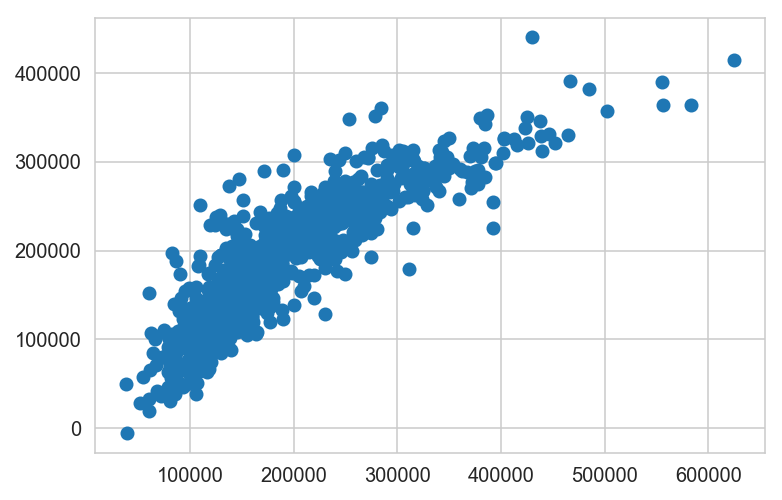

In [177]:
predictions = lm.predict(Xs)
linear_plot = plt.scatter(y, predictions)

## Train & Test Model with 'PropAge',  'TotalArea', 'TotalBath' for Neighborhood = NAmes

In [185]:
#### Create a model by separating the neighborhood

house_clean.Neighborhood.value_counts()

NAmes      223
CollgCr    150
OldTown    110
Edwards     96
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     39
Timber      38
IDOTRR      28
ClearCr     28
StoneBr     25
SWISU       25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [222]:
house_clean[house_clean['Neighborhood'] == 'NAmes'][fixed_fts_gd]

,PropAge,TotalArea,TotalBath
14,48,2858,3
16,40,2488,2
19,51,2662,1
26,59,2376,2
28,49,3403,2
33,51,3545,3
37,55,3092,2
38,57,2360,2
40,41,2852,2
44,47,2600,2


In [216]:
house_clean[['Neighborhood'] == 'NAmes']
#[fixed_fts_gd]

KeyError: False

In [213]:
house_clean_NAmes = house_clean[fixed_fts_gd][['Neighborhood'] == 'NAmes']
house_clean_NAmes.shape

KeyError: False

C:\Users\norik\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\norik\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\norik\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\norik\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\norik\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler

0.5743341641423911
0.5523795474326676


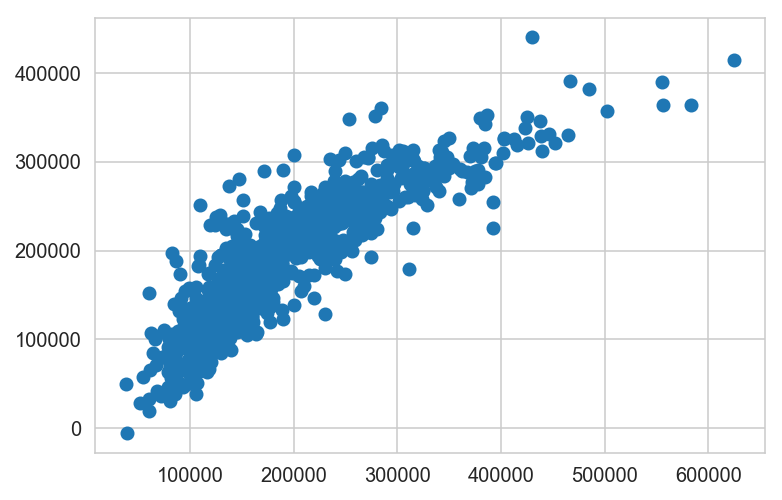

In [223]:
fixed_fts_gd = ['PropAge', 'TotalArea', 'TotalBath' ]

house_fixed = house_clean[fixed_fts_gd]

house_clean_NAmes = house_clean[house_clean['Neighborhood'] == 'NAmes'][fixed_fts_gd]


# Train model on pre-2010 model and test with 2010 data

fixed_pre2010_NAmes = house_clean_NAmes[house_clean.YrSold<2010]
fixed_post2010_NAmes = house_clean_NAmes[house_clean.YrSold>2009]
#fixed_post2010.shape


# Create a dataframe for dependent variable, SalePrice
SalePrice_pre2010_NAmes = house_clean['SalePrice'][(house_clean.YrSold<2010) & (house_clean['Neighborhood'] == 'NAmes')]
SalePrice_post2010_NAmes = house_clean['SalePrice'][(house_clean.YrSold>2009) & (house_clean['Neighborhood'] == 'NAmes')]


# Train the model with pre-2010 data points
y_NAmes = SalePrice_pre2010_NAmes # y_train
X_NAmes = fixed_pre2010_NAmes     # x_train


# Standardise the X_train features
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs_NAmes = ss.fit_transform(X_NAmes)


# Retrieve test data set
y_test_NAmes = SalePrice_post2010_NAmes
X_test_NAmes = fixed_post2010_NAmes


# Standardise X_test features
Xs_test_NAmes = ss.fit_transform(X_test_NAmes)

# Linear Regression

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict


lm = LinearRegression()
lm.fit(Xs_NAmes, y_NAmes)


linear_test_error=lm.score(Xs_test_NAmes, y_test_NAmes)
linear_train_error=lm.score(Xs_NAmes, y_NAmes)

print(lm.score(Xs_test_NAmes, y_test_NAmes))
print(lm.score(Xs_NAmes, y_NAmes))


predictions_NAmes= lm.predict(Xs_NAmes)
linear_plot=plt.scatter(y, predictions)

### Selecting features using Sci-Kit Learn

In [233]:
house_clean.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

###  Choose 'Fixed' characteristics of a property that cannot be renovated or there are too many null cells.

In [239]:
fixed_fts_unsorted = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 
            'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
            'YearBuilt', 'YearRemodAdd', 'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2','BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 
            'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
            'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'MiscVal',
            'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'PropAge', 'PropRemAge', 'TotalHomeArea', 'TotalArea',
            'TotalBath']

# Note we will not include 'SalePrice' as it is a target variable.

In [ ]:
We will observe the scores and decide which features to be removed.
We will also need to remove multicolinear features.

In [243]:
house_clean[fixed_fts_unsorted].dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
LotShape          object
LandContour       object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
YearBuilt          int64
YearRemodAdd       int64
MasVnrType        object
MasVnrArea        object
Foundation        object
BsmtExposure      object
BsmtFinType1      object
BsmtFinType2      object
BsmtFinSF1         int64
BsmtFinSF2         int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageType        object
GarageYrBlt       object
GarageFinish      object
GarageCars         int64


#### Create dummies for categorical features

First, we will create a list of categorical features.

In [245]:
fixed_cat_unsorted = []

for elem in fixed_fts_unsorted:
    if house_clean[elem].dtype != np.int64 and house_clean[elem].dtype != np.float64:
        fixed_cat_unsorted.append(elem)

In [247]:
print(fixed_cat_unsorted)
print('There are ', len(fixed_cat_unsorted), ' fixed categorical features.')

['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'SaleType', 'SaleCondition']
There are  22  fixed categorical features.


In [248]:
# Create dummy variables for categorical features

# 

for elem in fixed_fts_cat:
    dummy = pd.get_dummies(house_clean[elem])
    house_fixed = pd.concat([house_clean, dummy], axis = 1)



#fixed_house=pd.get_dummies(fixed_house,drop_first=True)

In [249]:
house_fixed.shape

(1440, 88)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: